online

if random.choice([0,1,1,1,]):
[0.859, 0.86, 0.861, 0.843, 0.855] 0.8556000000000001

[0.8789124971441612, 0.8831880936061866, 0.8818342151675468, 0.8683454177281323, 0.8759553203997628] 0.877647108809158

online 0.7916984126984127

In [1]:
seed = 0
import random
import numpy as np
import tensorflow as tf
import os
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTHONHASHSEED"] = str(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    except RuntimeError as e:
        print(e)

In [2]:
import numpy as np
import pandas as pd
# 选择比较好的模型
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy

from sklearn.preprocessing import StandardScaler,MinMaxScaler
%load_ext autoreload
%autoreload 2

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
        '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
        '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[str(int(y))], mapping[str(int(y_pred))]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

sample_num = 60

In [3]:
!ls ../../data

final_data


In [4]:
root_path  = '../../data/final_data/'
train = pd.read_csv(root_path+'sensor_train_final.csv')
test = pd.read_csv(root_path+'sensor_test_final.csv')
sub = pd.read_csv(root_path+'submit_example.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [5]:
def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
    df['thetax']=np.arctan(df.acc_xg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetay']=np.arctan(df.acc_yg/
                           np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetaz']=np.arctan(df.acc_zg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi

    df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
    df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5    
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df
train=add_features(train)
test=add_features(test)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'accg', 'thetax', 'thetay',
       'thetaz', 'xy', 'xy_g', 'g'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay', 'thetaz', 'xy',
       'xy_g', 'g'],
      dtype='object')


In [6]:
group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
print(group1)

train = train[['fragment_id', 'time_point', 'behavior_id']+group1]
test = test[['fragment_id', 'time_point']+group1]

['acc_x', 'acc_y', 'acc_z', 'acc_xg', 'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay', 'thetaz', 'xy', 'xy_g', 'g']


In [7]:
FEATURE_NUM=14

In [8]:
len(set(train['fragment_id'])),len(set(test['fragment_id']))

(15000, 16000)

In [9]:

x = np.zeros((15000, sample_num, FEATURE_NUM, 1))
t = np.zeros((16000, sample_num, FEATURE_NUM, 1))

In [10]:
def df2array(df,num,x):
    for i in tqdm(range(num)):
        tmp = df[df.fragment_id == i][:sample_num]
        length=len(tmp)
        if length<50:
            new_tmp=tmp.copy()
            while len(tmp)<60:
                new_tmp['time_point']=tmp['time_point'].max()+new_tmp['time_point']
                tmp=pd.concat([tmp,new_tmp],ignore_index=True)
        x[i,:,:,0] = resample(tmp[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,FEATURE_NUM)
    return x
x=df2array(train,15000,x)
t=df2array(test,16000,t)

100%|██████████| 16000/16000 [00:48<00:00, 332.69it/s]


In [17]:
%%time
# 一个完成了的generator
def data_generator(data,label,class17label,batch_size):
    """
    data:array  (7292, 60, 14, 1)
    label:array (7292,)
    class17label: series
    """
    class17label=np.asarray(class17label)
    length=len(data)
    seq_length=len(data[0])
    half_seq_length=int(seq_length/2)
    
    # index2label
    index2label=dict(zip(range(length),class17label))
    
    label2index={}
#     print(class17label)
    for i in range(length):
#         print(class17label[i],label2index.get(class17label[i],[]))
        label2index[class17label[i]]=label2index.get(class17label[i],[])
        label2index[class17label[i]].append(i)

    count=0
    np.random.seed(seed)# 保证结果可重复
    
    while True:
        
        if count==0 or (count + 1) * batch_size > length:  # 如果是第一个或者最后一个batch
            count=0
            shuffle_index = list(range(length))
            np.random.shuffle(shuffle_index)   ## 对索引进行打乱
        
        start = count * batch_size  ## batch的起始点
        end = (count + 1) * batch_size ## batch的终点
        inds=shuffle_index[start:end]

        count+=1
        
        if random.choice([0,1,1,1]):
            # minxup
            #one specific index -> label -> all the index belong to this
            choice_index=[random.choice(label2index[index2label[x]]) for x in inds]   # get the random choice seq(waiting for concat)
            # 1st 前1/2 seq_length 点原始  后1/2 seq_length 点随机
            res_x_orig=data[inds,:half_seq_length]   #原始
            res_x=data[choice_index,half_seq_length:]   #需要加入的

    #         print(inds)
    #         print(data.shape,res_x_orig.shape,res_x.shape,np.concatenate((res_x_orig,res_x),axis=1).shape)
            yield np.concatenate((res_x_orig,res_x),axis=1),\
                    [label[0][inds],label[1][inds],label[2][inds]]
        else:
        
            yield data[inds],[label[0][inds],label[1][inds],label[2][inds]]
            
    

count=0
for a,b in data_generator(x,[y,y,y],y,32):
    print(a.shape,b[0].shape)
    count+=1
    if count==20:
        break


(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
CPU times: user 37.2 ms, sys: 2.31 ms, total: 39.5 ms
Wall time: 37 ms


In [18]:
def ConvBNRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
#                activation='relu',
               use_bias=False,
               padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X


def ConvRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
               activation='relu',
               use_bias=False,
               padding='same')(X)
    return X


def squeeze_excitation_layer(x, out_dim,ratio=8):
    '''
    SE module performs inter-channel weighting.
    '''
    squeeze = GlobalAveragePooling2D()(x)

    excitation = Dense(units=out_dim // ratio)(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Dense(units=out_dim)(excitation)
    excitation = Activation('sigmoid')(excitation)
    excitation = Reshape((1,1,out_dim))(excitation)
    scale = multiply([x,excitation])
    return scale

# def SE_Residual(X):
#     A = 
#     X = squeeze_excitation_layer(X,128)
#     X =  Add()([X,A])
    

def lenet5(input):
    A = ConvBNRelu(input,64,kernal_size=(3,3))
#     B = ConvBNRelu(input,16,kernal_size=(5,1))
#     C = ConvBNRelu(input,16,kernal_size=(7,1))
#     ABC = layers.Concatenate()([A,B,C])
    X = ConvBNRelu(A,128)
#     X = squeeze_excitation_layer(X,128)
    X = Dropout(0.2)(X)

    X = AveragePooling2D()(X)
    
    X = ConvBNRelu(X,256)
    X = Dropout(0.3)(X)
#     X = squeeze_excitation_layer(X,256)
    X = ConvBNRelu(X,512)   
    X = Dropout(0.5)(X)
#     X = squeeze_excitation_layer(X,512)
#     X = GlobalMaxPooling2D()(X)
    X = GlobalAveragePooling2D()(X)
    
#     X = BatchNormalization()(X)
    return X
import tensorflow as tf
def Net(sample_num):
    input1 = Input(shape=(sample_num, FEATURE_NUM, 1))
    part = tf.split(input1,axis=2, num_or_size_splits = [6, 2, 6])
#     res = tf.split(c, axis = 3, num_or_size_splits = [2, 2, 4])
    
    
    X1 = Concatenate(axis=-2)([part[0],part[1]])
    X1 = lenet5(X1)
    X1 = BatchNormalization()(X1)
    X1 = Dense(128, activation='relu')(X1)
    X1 = BatchNormalization()(X1)
    X1 = Dropout(0.2)(X1)

    X2 = Concatenate(axis=-2)([part[0],part[2]])
    X2 = lenet5(X2)    
    X2 = BatchNormalization()(X2)
#     X = Dense(512, activation='relu')(X)
#     X = BatchNormalization()(X)
    X2 = Dense(128, activation='relu')(X2)
    X2 = BatchNormalization()(X2)
    X2 = Dropout(0.2)(X2)
    
    X = Concatenate(axis=-1)([X1,X2])
    
#     X = Dense(256)(X)    
    
    output1 = Dense(8, activation='softmax', name='4class')(X)   # 大类-字母
#     output2 = Dense(128)(X)
#     output2 = Dense(64)(X)
    X = Dense(64)(X)
    output2 = Dense(10, activation='softmax', name='7class')(X)   # 大类-数字
#     X = Dense(32)(X)
#     X = Concatenate(axis=-1)([X,output1,output2])
    X = Dense(64)(X)
    output3 = Dense(20, activation='softmax',name='19class')(X) #小类
    
    
    return Model([input1], [output1,output2,output3])

# model = Net(60)
# model.summary()

In [19]:
# 两个输出    
mapping = {
    '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
    '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
    '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
          }

# 每一个大类输出 4
new_mapping = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}

from sklearn.utils.class_weight import compute_class_weight
# # y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights1=compute_class_weight("balanced",['A','B','C','D','E','F','G','H'],\
                                   pd.read_csv(root_path+'sensor_train_final.csv')['behavior_id'].apply(lambda x:mapping[str(x)][0]))
classweights1=pd.DataFrame(classweights1)[0].to_dict()
# classweights1


tmp=pd.read_csv(root_path+'sensor_train_final.csv')['behavior_id'].apply(lambda x:mapping[str(x)][2])
tmp=[int(x) for x in tmp]
classweights2=compute_class_weight("balanced",list(range(10)),tmp)
classweights2=pd.DataFrame(classweights2)[0].to_dict()
classweights2

# y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights3=compute_class_weight("balanced",np.array(range(20)), pd.read_csv(root_path+'sensor_train_final.csv')['behavior_id'])
classweights3=pd.DataFrame(classweights3)[0].to_dict()
classweights1,classweights2,classweights3

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], y=0         C
1         C
2         C
3         C
4         C
         ..
391789    E
391790    E
391791    E
391792    E
391793    E
Name: behavior_id, Length: 391794, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], y=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 

({0: 0.5414510779436152,
  1: 0.43855835445191677,
  2: 0.5746600096218157,
  3: 2.7533732501264967,
  4: 2.6801428336890494,
  5: 4.144038754442376,
  6: 2.462626338814301,
  7: 1.3349938667030121},
 {0: 1.0679950933624096,
  1: 0.7043614267222782,
  2: 1.2670396481469504,
  3: 0.7505200850525832,
  4: 0.7652824439409329,
  5: 0.40225669668066405,
  6: 2.2026986001011974,
  7: 2.1441142669512394,
  8: 3.315231003553901,
  9: 1.9701010710514406},
 {0: 0.9323101085094232,
  1: 1.2855820973881087,
  2: 1.3505480868665978,
  3: 1.3001725625539258,
  4: 0.9258329788742379,
  5: 0.6896567505720824,
  6: 2.068606124604013,
  7: 0.5821258766195174,
  8: 0.9612217860647694,
  9: 1.376454468802698,
  10: 3.152510460251046,
  11: 1.184454924723381,
  12: 0.5542895138928188,
  13: 1.0019281914893616,
  14: 1.1817397599083066,
  15: 1.1013493000505987,
  16: 1.0720571334756197,
  17: 1.6576155017769505,
  18: 0.9850505355257203,
  19: 0.5339975466812048})

In [23]:
# [:,:,:,[1]]
train = x
test = t

    
fold_num=5

proba_t = np.zeros((16000, 20))
proba_oof = np.zeros((15000,20))

oof_score = []
oof_comm = []
history = []

from tensorflow.keras.losses import categorical_crossentropy
def custom_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

# 两个输出    
mapping = {
    0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
    9: 'C_1', 10: 'A_2', 11: 'C_3', 12: 'B_5', 13: 'B_4', 14: 'C_4', 
    15: 'D_6', 16: 'E_7', 17: 'F_8',18: 'G_9', 19: 'H_0'
          }
# 每一个大类输出 4
new_mapping = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}
y_1 = to_categorical([new_mapping[mapping[x][0]] for x in y], num_classes=8)
# 每一个大类输出 
y_2 = to_categorical([mapping[x][2] for x in y], num_classes=10)
# 每一个小类的输出 19
y_3 = to_categorical(y, num_classes=20)

# seeds=[0,42,2020,666,888,6699,6969]
seeds=[42]
for seed in seeds:
    kfold = StratifiedKFold(fold_num,random_state=seed,shuffle=True)
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    for fold, (xx, yy) in enumerate(kfold.split(train, y)):

        model = Net(60)
        model.summary()
        model.compile(loss=[custom_loss,custom_loss,custom_loss],loss_weights=[3,7,21],
                      optimizer=Adam(),
                      metrics=["acc"])#'',localscore

        plateau3 = ReduceLROnPlateau(monitor="19class_acc",
                                    verbose=1,
                                    mode='max',
                                    factor=0.5,
                                    patience=18)
        early_stopping = EarlyStopping(monitor="val_19class_acc",
                                       verbose=1,
                                       mode='max',
                                       patience=60)

        checkpoint = ModelCheckpoint(f'all_stragety{fold}.h5',
                                     monitor="val_19class_acc",
                                     verbose=0,
                                     mode='max',
                                     save_best_only=True)

        train_res = model.fit_generator(data_generator(train[xx], [y_1[xx], y_2[xx], y_3[xx]],y[xx],256),
                  epochs=1000,
                  steps_per_epoch=len(xx) // 256,
                  verbose=1,
                  shuffle=True,
                  validation_data=(train[yy], [y_1[yy], y_2[yy],y_3[yy]]),
                  callbacks=[plateau3, early_stopping, checkpoint],
                             class_weight=[classweights1,classweights2,classweights3]
                             )

        history.append(train_res)

        model.load_weights(f'all_stragety{fold}.h5')
        proba_t += model.predict(test, verbose=0, batch_size=1024)[2] / (fold_num*len(seeds))
        proba_oof[yy] += model.predict(train[yy],verbose=0,batch_size=1024) [2]

        oof_y = np.argmax(proba_oof[yy], axis=1)
        acc = round(accuracy_score(y[yy], oof_y),3)
        print(acc)
        oof_score.append(acc)
        scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
        oof_comm.append(scores)   
        print(round(scores, 5))


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60, 14, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_4 (TensorFlow [(None, 60, 6, 1), ( 0           input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 60, 8, 1)     0           tf_op_layer_split_4[0][0]        
                                                                 tf_op_layer_split_4[0][1]        
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 60, 12, 1)    0           tf_op_layer_split_4[0][0]  

46/46 [==============================] - 11s 244ms/step - loss: 60.1144 - 4class_loss: 1.5702 - 7class_loss: 1.6712 - 19class_loss: 2.0812 - 4class_acc: 0.4017 - 7class_acc: 0.4421 - 19class_acc: 0.3918 - val_loss: 96.8425 - val_4class_loss: 2.9065 - val_7class_loss: 2.7021 - val_19class_loss: 3.2956 - val_4class_acc: 0.1020 - val_7class_acc: 0.1213 - val_19class_acc: 0.0940
Epoch 2/1000
46/46 [==============================] - 10s 210ms/step - loss: 46.6973 - 4class_loss: 1.2375 - 7class_loss: 1.3200 - 19class_loss: 1.6069 - 4class_acc: 0.5386 - 7class_acc: 0.5390 - 19class_acc: 0.5183 - val_loss: 82.7771 - val_4class_loss: 1.9467 - val_7class_loss: 2.0614 - val_19class_loss: 2.9765 - val_4class_acc: 0.1360 - val_7class_acc: 0.3233 - val_19class_acc: 0.2030
Epoch 3/1000
46/46 [==============================] - 10s 210ms/step - loss: 41.9157 - 4class_loss: 1.0845 - 7class_loss: 1.1767 - 19class_loss: 1.4488 - 4class_acc: 0.6191 - 7class_acc: 0.6034 - 19class_acc: 0.5833 - val_loss: 73.

Epoch 22/1000
46/46 [==============================] - 12s 263ms/step - loss: 27.0655 - 4class_loss: 0.6772 - 7class_loss: 0.7498 - 19class_loss: 0.9422 - 4class_acc: 0.8076 - 7class_acc: 0.8021 - 19class_acc: 0.7804 - val_loss: 58.4717 - val_4class_loss: 1.2187 - val_7class_loss: 1.7132 - val_19class_loss: 2.0392 - val_4class_acc: 0.6630 - val_7class_acc: 0.5270 - val_19class_acc: 0.5083
Epoch 23/1000
46/46 [==============================] - 12s 267ms/step - loss: 27.9086 - 4class_loss: 0.6992 - 7class_loss: 0.7788 - 19class_loss: 0.9695 - 4class_acc: 0.7994 - 7class_acc: 0.7926 - 19class_acc: 0.7723 - val_loss: 72.6489 - val_4class_loss: 1.5450 - val_7class_loss: 1.9014 - val_19class_loss: 2.6050 - val_4class_acc: 0.6010 - val_7class_acc: 0.4880 - val_19class_acc: 0.4287
Epoch 24/1000
46/46 [==============================] - 11s 250ms/step - loss: 26.0703 - 4class_loss: 0.6590 - 7class_loss: 0.7257 - 19class_loss: 0.9054 - 4class_acc: 0.8150 - 7class_acc: 0.8170 - 19class_acc: 0.7955

Epoch 43/1000
46/46 [==============================] - 9s 206ms/step - loss: 21.2483 - 4class_loss: 0.5390 - 7class_loss: 0.5889 - 19class_loss: 0.7385 - 4class_acc: 0.8714 - 7class_acc: 0.8747 - 19class_acc: 0.8570 - val_loss: 75.5941 - val_4class_loss: 1.8112 - val_7class_loss: 2.0461 - val_19class_loss: 2.6589 - val_4class_acc: 0.6043 - val_7class_acc: 0.5303 - val_19class_acc: 0.4943
Epoch 44/1000
46/46 [==============================] - 9s 207ms/step - loss: 21.0866 - 4class_loss: 0.5415 - 7class_loss: 0.5901 - 19class_loss: 0.7301 - 4class_acc: 0.8706 - 7class_acc: 0.8788 - 19class_acc: 0.8643 - val_loss: 58.6593 - val_4class_loss: 1.1936 - val_7class_loss: 1.7142 - val_19class_loss: 2.0514 - val_4class_acc: 0.6877 - val_7class_acc: 0.5857 - val_19class_acc: 0.5587
Epoch 45/1000
46/46 [==============================] - 9s 206ms/step - loss: 20.6034 - 4class_loss: 0.5304 - 7class_loss: 0.5765 - 19class_loss: 0.7132 - 4class_acc: 0.8809 - 7class_acc: 0.8812 - 19class_acc: 0.8678 - 

Epoch 64/1000
46/46 [==============================] - 9s 205ms/step - loss: 17.7702 - 4class_loss: 0.4580 - 7class_loss: 0.4999 - 19class_loss: 0.6141 - 4class_acc: 0.9154 - 7class_acc: 0.9156 - 19class_acc: 0.9028 - val_loss: 57.4903 - val_4class_loss: 1.3763 - val_7class_loss: 1.5743 - val_19class_loss: 2.0163 - val_4class_acc: 0.6703 - val_7class_acc: 0.5980 - val_19class_acc: 0.5697
Epoch 65/1000
46/46 [==============================] - 9s 206ms/step - loss: 19.5617 - 4class_loss: 0.5041 - 7class_loss: 0.5437 - 19class_loss: 0.6783 - 4class_acc: 0.8944 - 7class_acc: 0.8992 - 19class_acc: 0.8800 - val_loss: 62.4797 - val_4class_loss: 1.3085 - val_7class_loss: 1.8277 - val_19class_loss: 2.1790 - val_4class_acc: 0.6790 - val_7class_acc: 0.5727 - val_19class_acc: 0.5553
Epoch 66/1000
46/46 [==============================] - 10s 207ms/step - loss: 19.5198 - 4class_loss: 0.5033 - 7class_loss: 0.5414 - 19class_loss: 0.6771 - 4class_acc: 0.8911 - 7class_acc: 0.8968 - 19class_acc: 0.8805 -

Epoch 85/1000
46/46 [==============================] - 10s 208ms/step - loss: 16.6313 - 4class_loss: 0.4377 - 7class_loss: 0.4647 - 19class_loss: 0.5745 - 4class_acc: 0.9264 - 7class_acc: 0.9327 - 19class_acc: 0.9220 - val_loss: 48.4684 - val_4class_loss: 1.0564 - val_7class_loss: 1.3182 - val_19class_loss: 1.7177 - val_4class_acc: 0.7403 - val_7class_acc: 0.6747 - val_19class_acc: 0.6343
Epoch 86/1000
46/46 [==============================] - 10s 212ms/step - loss: 16.2100 - 4class_loss: 0.4254 - 7class_loss: 0.4547 - 19class_loss: 0.5596 - 4class_acc: 0.9338 - 7class_acc: 0.9372 - 19class_acc: 0.9264 - val_loss: 50.6885 - val_4class_loss: 1.1917 - val_7class_loss: 1.4401 - val_19class_loss: 1.7635 - val_4class_acc: 0.7103 - val_7class_acc: 0.6563 - val_19class_acc: 0.6177
Epoch 87/1000
46/46 [==============================] - 9s 205ms/step - loss: 17.3907 - 4class_loss: 0.4488 - 7class_loss: 0.4836 - 19class_loss: 0.6028 - 4class_acc: 0.9165 - 7class_acc: 0.9215 - 19class_acc: 0.9056 

Epoch 106/1000
46/46 [==============================] - 9s 201ms/step - loss: 14.1906 - 4class_loss: 0.3807 - 7class_loss: 0.4021 - 19class_loss: 0.4873 - 4class_acc: 0.9581 - 7class_acc: 0.9648 - 19class_acc: 0.9561 - val_loss: 39.2330 - val_4class_loss: 0.9210 - val_7class_loss: 1.1531 - val_19class_loss: 1.3523 - val_4class_acc: 0.7803 - val_7class_acc: 0.7347 - val_19class_acc: 0.7050
Epoch 107/1000
46/46 [==============================] - 10s 208ms/step - loss: 15.0457 - 4class_loss: 0.3965 - 7class_loss: 0.4201 - 19class_loss: 0.5198 - 4class_acc: 0.9437 - 7class_acc: 0.9512 - 19class_acc: 0.9409 - val_loss: 39.3455 - val_4class_loss: 0.9590 - val_7class_loss: 1.1388 - val_19class_loss: 1.3570 - val_4class_acc: 0.7717 - val_7class_acc: 0.7257 - val_19class_acc: 0.7050
Epoch 108/1000
46/46 [==============================] - 9s 204ms/step - loss: 15.3171 - 4class_loss: 0.4030 - 7class_loss: 0.4286 - 19class_loss: 0.5289 - 4class_acc: 0.9429 - 7class_acc: 0.9480 - 19class_acc: 0.934

Epoch 127/1000
46/46 [==============================] - 9s 203ms/step - loss: 14.5253 - 4class_loss: 0.3821 - 7class_loss: 0.4088 - 19class_loss: 0.5008 - 4class_acc: 0.9562 - 7class_acc: 0.9549 - 19class_acc: 0.9479 - val_loss: 51.0296 - val_4class_loss: 1.1288 - val_7class_loss: 1.4874 - val_19class_loss: 1.7729 - val_4class_acc: 0.7367 - val_7class_acc: 0.6633 - val_19class_acc: 0.6330
Epoch 128/1000
46/46 [==============================] - 9s 203ms/step - loss: 14.2084 - 4class_loss: 0.3811 - 7class_loss: 0.4012 - 19class_loss: 0.4884 - 4class_acc: 0.9552 - 7class_acc: 0.9612 - 19class_acc: 0.9535 - val_loss: 43.8484 - val_4class_loss: 0.9898 - val_7class_loss: 1.2171 - val_19class_loss: 1.5409 - val_4class_acc: 0.7767 - val_7class_acc: 0.7070 - val_19class_acc: 0.6687
Epoch 129/1000
46/46 [==============================] - 9s 203ms/step - loss: 14.2056 - 4class_loss: 0.3802 - 7class_loss: 0.3991 - 19class_loss: 0.4891 - 4class_acc: 0.9564 - 7class_acc: 0.9619 - 19class_acc: 0.9548

Epoch 148/1000
46/46 [==============================] - 10s 207ms/step - loss: 13.2117 - 4class_loss: 0.3540 - 7class_loss: 0.3742 - 19class_loss: 0.4538 - 4class_acc: 0.9693 - 7class_acc: 0.9722 - 19class_acc: 0.9683 - val_loss: 34.0536 - val_4class_loss: 0.8114 - val_7class_loss: 0.9898 - val_19class_loss: 1.1757 - val_4class_acc: 0.8157 - val_7class_acc: 0.7730 - val_19class_acc: 0.7460
Epoch 149/1000
46/46 [==============================] - 9s 201ms/step - loss: 13.5076 - 4class_loss: 0.3606 - 7class_loss: 0.3835 - 19class_loss: 0.4639 - 4class_acc: 0.9682 - 7class_acc: 0.9710 - 19class_acc: 0.9654 - val_loss: 34.4836 - val_4class_loss: 0.8464 - val_7class_loss: 0.9625 - val_19class_loss: 1.2003 - val_4class_acc: 0.8123 - val_7class_acc: 0.7837 - val_19class_acc: 0.7510
Epoch 150/1000
46/46 [==============================] - 9s 201ms/step - loss: 14.0709 - 4class_loss: 0.3717 - 7class_loss: 0.3961 - 19class_loss: 0.4849 - 4class_acc: 0.9575 - 7class_acc: 0.9649 - 19class_acc: 0.957

Epoch 169/1000
46/46 [==============================] - 9s 204ms/step - loss: 12.8070 - 4class_loss: 0.3440 - 7class_loss: 0.3635 - 19class_loss: 0.4395 - 4class_acc: 0.9736 - 7class_acc: 0.9772 - 19class_acc: 0.9728 - val_loss: 36.6883 - val_4class_loss: 0.8558 - val_7class_loss: 1.0449 - val_19class_loss: 1.2765 - val_4class_acc: 0.8127 - val_7class_acc: 0.7707 - val_19class_acc: 0.7397
Epoch 170/1000
46/46 [==============================] - 9s 206ms/step - loss: 12.5471 - 4class_loss: 0.3388 - 7class_loss: 0.3572 - 19class_loss: 0.4300 - 4class_acc: 0.9781 - 7class_acc: 0.9831 - 19class_acc: 0.9774 - val_loss: 34.9916 - val_4class_loss: 0.8665 - val_7class_loss: 0.9792 - val_19class_loss: 1.2161 - val_4class_acc: 0.8177 - val_7class_acc: 0.7823 - val_19class_acc: 0.7453
Epoch 171/1000
46/46 [==============================] - 10s 207ms/step - loss: 13.3970 - 4class_loss: 0.3561 - 7class_loss: 0.3776 - 19class_loss: 0.4612 - 4class_acc: 0.9691 - 7class_acc: 0.9713 - 19class_acc: 0.963

46/46 [==============================] - 9s 205ms/step - loss: 11.5785 - 4class_loss: 0.3179 - 7class_loss: 0.3333 - 19class_loss: 0.3948 - 4class_acc: 0.9879 - 7class_acc: 0.9911 - 19class_acc: 0.9894 - val_loss: 32.8925 - val_4class_loss: 0.7979 - val_7class_loss: 0.9387 - val_19class_loss: 1.1394 - val_4class_acc: 0.8327 - val_7class_acc: 0.7953 - val_19class_acc: 0.7667
Epoch 190/1000
46/46 [==============================] - 12s 264ms/step - loss: 11.6556 - 4class_loss: 0.3206 - 7class_loss: 0.3362 - 19class_loss: 0.3972 - 4class_acc: 0.9872 - 7class_acc: 0.9907 - 19class_acc: 0.9873 - val_loss: 28.8146 - val_4class_loss: 0.7118 - val_7class_loss: 0.8142 - val_19class_loss: 0.9990 - val_4class_acc: 0.8597 - val_7class_acc: 0.8367 - val_19class_acc: 0.8110
Epoch 191/1000
46/46 [==============================] - 10s 208ms/step - loss: 11.5482 - 4class_loss: 0.3185 - 7class_loss: 0.3324 - 19class_loss: 0.3936 - 4class_acc: 0.9873 - 7class_acc: 0.9932 - 19class_acc: 0.9893 - val_loss: 

46/46 [==============================] - 9s 202ms/step - loss: 11.3338 - 4class_loss: 0.3118 - 7class_loss: 0.3280 - 19class_loss: 0.3858 - 4class_acc: 0.9900 - 7class_acc: 0.9931 - 19class_acc: 0.9913 - val_loss: 28.1378 - val_4class_loss: 0.7094 - val_7class_loss: 0.7985 - val_19class_loss: 0.9724 - val_4class_acc: 0.8580 - val_7class_acc: 0.8393 - val_19class_acc: 0.8127
Epoch 210/1000
46/46 [==============================] - 9s 201ms/step - loss: 11.2027 - 4class_loss: 0.3106 - 7class_loss: 0.3259 - 19class_loss: 0.3805 - 4class_acc: 0.9917 - 7class_acc: 0.9941 - 19class_acc: 0.9935 - val_loss: 27.9427 - val_4class_loss: 0.7045 - val_7class_loss: 0.7916 - val_19class_loss: 0.9661 - val_4class_acc: 0.8627 - val_7class_acc: 0.8407 - val_19class_acc: 0.8150
Epoch 211/1000
46/46 [==============================] - 9s 204ms/step - loss: 11.2542 - 4class_loss: 0.3097 - 7class_loss: 0.3258 - 19class_loss: 0.3831 - 4class_acc: 0.9917 - 7class_acc: 0.9946 - 19class_acc: 0.9925 - val_loss: 28

Epoch 230/1000
46/46 [==============================] - 9s 203ms/step - loss: 10.9946 - 4class_loss: 0.3047 - 7class_loss: 0.3206 - 19class_loss: 0.3732 - 4class_acc: 0.9946 - 7class_acc: 0.9964 - 19class_acc: 0.9948 - val_loss: 27.7022 - val_4class_loss: 0.7011 - val_7class_loss: 0.7881 - val_19class_loss: 0.9563 - val_4class_acc: 0.8633 - val_7class_acc: 0.8440 - val_19class_acc: 0.8200
Epoch 231/1000
46/46 [==============================] - 9s 202ms/step - loss: 11.1799 - 4class_loss: 0.3078 - 7class_loss: 0.3236 - 19class_loss: 0.3806 - 4class_acc: 0.9927 - 7class_acc: 0.9944 - 19class_acc: 0.9920 - val_loss: 27.7519 - val_4class_loss: 0.6994 - val_7class_loss: 0.7815 - val_19class_loss: 0.9611 - val_4class_acc: 0.8610 - val_7class_acc: 0.8430 - val_19class_acc: 0.8150
Epoch 232/1000
46/46 [==============================] - 9s 202ms/step - loss: 11.2690 - 4class_loss: 0.3110 - 7class_loss: 0.3265 - 19class_loss: 0.3834 - 4class_acc: 0.9913 - 7class_acc: 0.9934 - 19class_acc: 0.9916

46/46 [==============================] - 9s 205ms/step - loss: 10.7999 - 4class_loss: 0.3008 - 7class_loss: 0.3159 - 19class_loss: 0.3660 - 4class_acc: 0.9961 - 7class_acc: 0.9977 - 19class_acc: 0.9972 - val_loss: 27.4074 - val_4class_loss: 0.6946 - val_7class_loss: 0.7726 - val_19class_loss: 0.9484 - val_4class_acc: 0.8657 - val_7class_acc: 0.8460 - val_19class_acc: 0.8217
Epoch 251/1000
46/46 [==============================] - 9s 201ms/step - loss: 11.0097 - 4class_loss: 0.3054 - 7class_loss: 0.3206 - 19class_loss: 0.3738 - 4class_acc: 0.9930 - 7class_acc: 0.9960 - 19class_acc: 0.9949 - val_loss: 27.2848 - val_4class_loss: 0.6924 - val_7class_loss: 0.7684 - val_19class_loss: 0.9442 - val_4class_acc: 0.8633 - val_7class_acc: 0.8497 - val_19class_acc: 0.8217
Epoch 252/1000
46/46 [==============================] - 9s 199ms/step - loss: 11.0066 - 4class_loss: 0.3061 - 7class_loss: 0.3213 - 19class_loss: 0.3733 - 4class_acc: 0.9939 - 7class_acc: 0.9956 - 19class_acc: 0.9952 - val_loss: 27

46/46 [==============================] - 9s 203ms/step - loss: 10.8806 - 4class_loss: 0.3025 - 7class_loss: 0.3181 - 19class_loss: 0.3689 - 4class_acc: 0.9953 - 7class_acc: 0.9968 - 19class_acc: 0.9964 - val_loss: 27.0619 - val_4class_loss: 0.6878 - val_7class_loss: 0.7664 - val_19class_loss: 0.9349 - val_4class_acc: 0.8620 - val_7class_acc: 0.8470 - val_19class_acc: 0.8247
Epoch 271/1000
46/46 [==============================] - 9s 203ms/step - loss: 10.8048 - 4class_loss: 0.3001 - 7class_loss: 0.3157 - 19class_loss: 0.3664 - 4class_acc: 0.9963 - 7class_acc: 0.9972 - 19class_acc: 0.9968 - val_loss: 27.4052 - val_4class_loss: 0.6936 - val_7class_loss: 0.7772 - val_19class_loss: 0.9469 - val_4class_acc: 0.8637 - val_7class_acc: 0.8447 - val_19class_acc: 0.8183
Epoch 272/1000
46/46 [==============================] - 9s 203ms/step - loss: 10.7035 - 4class_loss: 0.2980 - 7class_loss: 0.3131 - 19class_loss: 0.3628 - 4class_acc: 0.9981 - 7class_acc: 0.9987 - 19class_acc: 0.9985 - val_loss: 27

Epoch 291/1000
46/46 [==============================] - 9s 203ms/step - loss: 10.7600 - 4class_loss: 0.2995 - 7class_loss: 0.3146 - 19class_loss: 0.3647 - 4class_acc: 0.9963 - 7class_acc: 0.9980 - 19class_acc: 0.9975 - val_loss: 26.9614 - val_4class_loss: 0.6877 - val_7class_loss: 0.7605 - val_19class_loss: 0.9321 - val_4class_acc: 0.8663 - val_7class_acc: 0.8503 - val_19class_acc: 0.8233
Epoch 292/1000
46/46 [==============================] - 9s 202ms/step - loss: 10.8691 - 4class_loss: 0.3021 - 7class_loss: 0.3176 - 19class_loss: 0.3685 - 4class_acc: 0.9964 - 7class_acc: 0.9974 - 19class_acc: 0.9972 - val_loss: 26.9772 - val_4class_loss: 0.6866 - val_7class_loss: 0.7579 - val_19class_loss: 0.9339 - val_4class_acc: 0.8637 - val_7class_acc: 0.8497 - val_19class_acc: 0.8223
Epoch 293/1000
46/46 [==============================] - 9s 202ms/step - loss: 10.8211 - 4class_loss: 0.3006 - 7class_loss: 0.3158 - 19class_loss: 0.3671 - 4class_acc: 0.9961 - 7class_acc: 0.9980 - 19class_acc: 0.9965

46/46 [==============================] - 9s 204ms/step - loss: 10.6841 - 4class_loss: 0.2981 - 7class_loss: 0.3132 - 19class_loss: 0.3618 - 4class_acc: 0.9971 - 7class_acc: 0.9988 - 19class_acc: 0.9985 - val_loss: 26.9770 - val_4class_loss: 0.6864 - val_7class_loss: 0.7617 - val_19class_loss: 0.9326 - val_4class_acc: 0.8657 - val_7class_acc: 0.8513 - val_19class_acc: 0.8253
Epoch 312/1000
46/46 [==============================] - 9s 201ms/step - loss: 10.7068 - 4class_loss: 0.2987 - 7class_loss: 0.3136 - 19class_loss: 0.3626 - 4class_acc: 0.9973 - 7class_acc: 0.9986 - 19class_acc: 0.9978 - val_loss: 27.1084 - val_4class_loss: 0.6905 - val_7class_loss: 0.7657 - val_19class_loss: 0.9370 - val_4class_acc: 0.8643 - val_7class_acc: 0.8480 - val_19class_acc: 0.8243
Epoch 313/1000
46/46 [==============================] - 9s 202ms/step - loss: 10.8309 - 4class_loss: 0.3019 - 7class_loss: 0.3168 - 19class_loss: 0.3670 - 4class_acc: 0.9959 - 7class_acc: 0.9970 - 19class_acc: 0.9973 - val_loss: 26

46/46 [==============================] - 10s 210ms/step - loss: 59.5594 - 4class_loss: 1.5636 - 7class_loss: 1.6671 - 19class_loss: 2.0571 - 4class_acc: 0.3943 - 7class_acc: 0.4522 - 19class_acc: 0.4003 - val_loss: 106.7950 - val_4class_loss: 2.1540 - val_7class_loss: 2.8515 - val_19class_loss: 3.8273 - val_4class_acc: 0.3067 - val_7class_acc: 0.2470 - val_19class_acc: 0.1730
Epoch 2/1000
46/46 [==============================] - 10s 209ms/step - loss: 44.8826 - 4class_loss: 1.1750 - 7class_loss: 1.2720 - 19class_loss: 1.5454 - 4class_acc: 0.5780 - 7class_acc: 0.5613 - 19class_acc: 0.5421 - val_loss: 78.3577 - val_4class_loss: 1.8866 - val_7class_loss: 2.1564 - val_19class_loss: 2.7430 - val_4class_acc: 0.2403 - val_7class_acc: 0.2833 - val_19class_acc: 0.1740
Epoch 3/1000
46/46 [==============================] - 9s 206ms/step - loss: 42.1201 - 4class_loss: 1.0542 - 7class_loss: 1.1893 - 19class_loss: 1.4587 - 4class_acc: 0.6305 - 7class_acc: 0.6017 - 19class_acc: 0.5670 - val_loss: 78.

Epoch 22/1000
46/46 [==============================] - 9s 202ms/step - loss: 25.8623 - 4class_loss: 0.6557 - 7class_loss: 0.7220 - 19class_loss: 0.8972 - 4class_acc: 0.8184 - 7class_acc: 0.8130 - 19class_acc: 0.7940 - val_loss: 61.9673 - val_4class_loss: 1.2667 - val_7class_loss: 1.6613 - val_19class_loss: 2.2161 - val_4class_acc: 0.6843 - val_7class_acc: 0.5867 - val_19class_acc: 0.5240
Epoch 23/1000
46/46 [==============================] - 9s 203ms/step - loss: 24.5430 - 4class_loss: 0.6232 - 7class_loss: 0.6944 - 19class_loss: 0.8482 - 4class_acc: 0.8340 - 7class_acc: 0.8233 - 19class_acc: 0.8118 - val_loss: 52.4372 - val_4class_loss: 1.0686 - val_7class_loss: 1.4526 - val_19class_loss: 1.8601 - val_4class_acc: 0.7007 - val_7class_acc: 0.5943 - val_19class_acc: 0.5693
Epoch 24/1000
46/46 [==============================] - 9s 201ms/step - loss: 26.3078 - 4class_loss: 0.6531 - 7class_loss: 0.7348 - 19class_loss: 0.9145 - 4class_acc: 0.8161 - 7class_acc: 0.8037 - 19class_acc: 0.7881 - 

Epoch 43/1000
46/46 [==============================] - 9s 202ms/step - loss: 21.0416 - 4class_loss: 0.5390 - 7class_loss: 0.5948 - 19class_loss: 0.7267 - 4class_acc: 0.8727 - 7class_acc: 0.8702 - 19class_acc: 0.8608 - val_loss: 73.1354 - val_4class_loss: 1.4787 - val_7class_loss: 2.0119 - val_19class_loss: 2.6008 - val_4class_acc: 0.6470 - val_7class_acc: 0.5680 - val_19class_acc: 0.5137
Epoch 44/1000
46/46 [==============================] - 9s 202ms/step - loss: 21.8394 - 4class_loss: 0.5558 - 7class_loss: 0.6101 - 19class_loss: 0.7572 - 4class_acc: 0.8670 - 7class_acc: 0.8678 - 19class_acc: 0.8510 - val_loss: 56.0620 - val_4class_loss: 1.2693 - val_7class_loss: 1.5183 - val_19class_loss: 1.9822 - val_4class_acc: 0.6873 - val_7class_acc: 0.6123 - val_19class_acc: 0.5650
Epoch 45/1000
46/46 [==============================] - 9s 202ms/step - loss: 19.8087 - 4class_loss: 0.5190 - 7class_loss: 0.5608 - 19class_loss: 0.6822 - 4class_acc: 0.8833 - 7class_acc: 0.8866 - 19class_acc: 0.8753 - 

Epoch 64/1000
46/46 [==============================] - 9s 204ms/step - loss: 17.4451 - 4class_loss: 0.4539 - 7class_loss: 0.4891 - 19class_loss: 0.6028 - 4class_acc: 0.9145 - 7class_acc: 0.9173 - 19class_acc: 0.9124 - val_loss: 48.6407 - val_4class_loss: 1.0830 - val_7class_loss: 1.3613 - val_19class_loss: 1.7078 - val_4class_acc: 0.7413 - val_7class_acc: 0.6590 - val_19class_acc: 0.6177
Epoch 65/1000
46/46 [==============================] - 9s 204ms/step - loss: 17.2329 - 4class_loss: 0.4483 - 7class_loss: 0.4846 - 19class_loss: 0.5950 - 4class_acc: 0.9180 - 7class_acc: 0.9184 - 19class_acc: 0.9113 - val_loss: 45.5641 - val_4class_loss: 1.1263 - val_7class_loss: 1.2481 - val_19class_loss: 1.5928 - val_4class_acc: 0.7127 - val_7class_acc: 0.6827 - val_19class_acc: 0.6417
Epoch 66/1000
46/46 [==============================] - 9s 202ms/step - loss: 17.8049 - 4class_loss: 0.4625 - 7class_loss: 0.4996 - 19class_loss: 0.6152 - 4class_acc: 0.9085 - 7class_acc: 0.9153 - 19class_acc: 0.9048 - 

Epoch 85/1000
46/46 [==============================] - 9s 204ms/step - loss: 16.4153 - 4class_loss: 0.4270 - 7class_loss: 0.4665 - 19class_loss: 0.5652 - 4class_acc: 0.9306 - 7class_acc: 0.9326 - 19class_acc: 0.9244 - val_loss: 41.1895 - val_4class_loss: 0.9128 - val_7class_loss: 1.1483 - val_19class_loss: 1.4482 - val_4class_acc: 0.7597 - val_7class_acc: 0.7243 - val_19class_acc: 0.6750
Epoch 86/1000
46/46 [==============================] - 9s 205ms/step - loss: 16.7333 - 4class_loss: 0.4368 - 7class_loss: 0.4683 - 19class_loss: 0.5783 - 4class_acc: 0.9273 - 7class_acc: 0.9305 - 19class_acc: 0.9186 - val_loss: 51.8416 - val_4class_loss: 1.1484 - val_7class_loss: 1.5009 - val_19class_loss: 1.8043 - val_4class_acc: 0.6983 - val_7class_acc: 0.6357 - val_19class_acc: 0.6010
Epoch 87/1000
46/46 [==============================] - 9s 204ms/step - loss: 15.1558 - 4class_loss: 0.4009 - 7class_loss: 0.4273 - 19class_loss: 0.5220 - 4class_acc: 0.9417 - 7class_acc: 0.9502 - 19class_acc: 0.9439 - 

Epoch 106/1000
46/46 [==============================] - 9s 203ms/step - loss: 15.4524 - 4class_loss: 0.4077 - 7class_loss: 0.4393 - 19class_loss: 0.5312 - 4class_acc: 0.9441 - 7class_acc: 0.9445 - 19class_acc: 0.9364 - val_loss: 34.5057 - val_4class_loss: 0.7880 - val_7class_loss: 0.9764 - val_19class_loss: 1.2051 - val_4class_acc: 0.8177 - val_7class_acc: 0.7740 - val_19class_acc: 0.7437
Epoch 107/1000
46/46 [==============================] - 9s 204ms/step - loss: 14.0452 - 4class_loss: 0.3736 - 7class_loss: 0.3961 - 19class_loss: 0.4834 - 4class_acc: 0.9557 - 7class_acc: 0.9644 - 19class_acc: 0.9573 - val_loss: 46.5531 - val_4class_loss: 0.9580 - val_7class_loss: 1.2748 - val_19class_loss: 1.6550 - val_4class_acc: 0.7503 - val_7class_acc: 0.6787 - val_19class_acc: 0.6420
Epoch 108/1000
46/46 [==============================] - 9s 204ms/step - loss: 14.7188 - 4class_loss: 0.3860 - 7class_loss: 0.4151 - 19class_loss: 0.5074 - 4class_acc: 0.9505 - 7class_acc: 0.9535 - 19class_acc: 0.9477

Epoch 127/1000
46/46 [==============================] - 9s 201ms/step - loss: 13.4962 - 4class_loss: 0.3605 - 7class_loss: 0.3812 - 19class_loss: 0.4641 - 4class_acc: 0.9658 - 7class_acc: 0.9710 - 19class_acc: 0.9641 - val_loss: 40.4561 - val_4class_loss: 0.9036 - val_7class_loss: 1.1612 - val_19class_loss: 1.4103 - val_4class_acc: 0.7913 - val_7class_acc: 0.7397 - val_19class_acc: 0.7043
Epoch 128/1000
46/46 [==============================] - 9s 200ms/step - loss: 13.8252 - 4class_loss: 0.3666 - 7class_loss: 0.3915 - 19class_loss: 0.4755 - 4class_acc: 0.9606 - 7class_acc: 0.9647 - 19class_acc: 0.9591 - val_loss: 32.6986 - val_4class_loss: 0.8209 - val_7class_loss: 0.8911 - val_19class_loss: 1.1428 - val_4class_acc: 0.8073 - val_7class_acc: 0.8037 - val_19class_acc: 0.7577
Epoch 129/1000
46/46 [==============================] - 9s 200ms/step - loss: 13.3844 - 4class_loss: 0.3625 - 7class_loss: 0.3819 - 19class_loss: 0.4583 - 4class_acc: 0.9692 - 7class_acc: 0.9724 - 19class_acc: 0.9677

Epoch 148/1000
46/46 [==============================] - 9s 203ms/step - loss: 13.2305 - 4class_loss: 0.3513 - 7class_loss: 0.3766 - 19class_loss: 0.4543 - 4class_acc: 0.9724 - 7class_acc: 0.9710 - 19class_acc: 0.9676 - val_loss: 47.5588 - val_4class_loss: 1.0943 - val_7class_loss: 1.3134 - val_19class_loss: 1.6706 - val_4class_acc: 0.7420 - val_7class_acc: 0.6833 - val_19class_acc: 0.6453
Epoch 149/1000
46/46 [==============================] - 9s 202ms/step - loss: 12.8545 - 4class_loss: 0.3431 - 7class_loss: 0.3675 - 19class_loss: 0.4406 - 4class_acc: 0.9766 - 7class_acc: 0.9787 - 19class_acc: 0.9738 - val_loss: 31.1743 - val_4class_loss: 0.7853 - val_7class_loss: 0.8566 - val_19class_loss: 1.0868 - val_4class_acc: 0.8317 - val_7class_acc: 0.8187 - val_19class_acc: 0.7797
Epoch 150/1000
46/46 [==============================] - 9s 201ms/step - loss: 13.2228 - 4class_loss: 0.3543 - 7class_loss: 0.3739 - 19class_loss: 0.4544 - 4class_acc: 0.9699 - 7class_acc: 0.9729 - 19class_acc: 0.9685

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46/46 [==============================] - 17s 362ms/step - loss: 10.7294 - 4class_loss: 0.2977 - 7class_loss: 0.3145 - 19class_loss: 0.3636 - 4class_acc: 0.9974 - 7class_acc: 0.9975 - 19class_acc: 0.9974 - val_loss: 25.5357 - val_4class_loss: 0.6588 - val_7class_loss: 0.6926 - val_19class_loss: 0.8910 - val_4class_acc: 0.8750 - val_7class_acc: 0.8673 - val_19class_acc: 0.8320
Epoch 294/1000
46/46 [==============================] - 17s 364ms/step - loss: 10.6929 - 4class_loss: 0.2970 - 7class_loss: 0.3130 - 19class_loss: 0.3624 - 4class_acc: 0.9975 - 7class_acc: 0.9980 - 19class_acc: 0.9980 - val_loss: 25.5511 - val_4class_loss: 0.6607 - val_7class_loss: 0.6914 - val_19class_loss: 0.8919 - val_4class_acc: 0.8733 - val_7class_acc: 0.8680 - val_19class_acc: 0.8310
Epoch 295/1000
46/46 [==============================] - 17s 366ms/step - loss: 10.6432 - 4class_loss: 0.2954 - 7class_loss: 0.3116 - 19class_loss: 0.3607 - 4class_acc: 0.9979 - 7class_acc: 0.9984 - 19class_acc: 0.9975 - val_loss:

Epoch 314/1000
46/46 [==============================] - 17s 361ms/step - loss: 10.6448 - 4class_loss: 0.2959 - 7class_loss: 0.3119 - 19class_loss: 0.3606 - 4class_acc: 0.9973 - 7class_acc: 0.9980 - 19class_acc: 0.9977 - val_loss: 25.4033 - val_4class_loss: 0.6582 - val_7class_loss: 0.6879 - val_19class_loss: 0.8864 - val_4class_acc: 0.8717 - val_7class_acc: 0.8707 - val_19class_acc: 0.8350
Epoch 315/1000
46/46 [==============================] - 17s 361ms/step - loss: 10.5888 - 4class_loss: 0.2946 - 7class_loss: 0.3101 - 19class_loss: 0.3588 - 4class_acc: 0.9983 - 7class_acc: 0.9988 - 19class_acc: 0.9981 - val_loss: 25.7057 - val_4class_loss: 0.6624 - val_7class_loss: 0.6979 - val_19class_loss: 0.8968 - val_4class_acc: 0.8690 - val_7class_acc: 0.8703 - val_19class_acc: 0.8337
Epoch 316/1000
46/46 [==============================] - 17s 362ms/step - loss: 10.6031 - 4class_loss: 0.2951 - 7class_loss: 0.3113 - 19class_loss: 0.3590 - 4class_acc: 0.9986 - 7class_acc: 0.9983 - 19class_acc: 0.9

Epoch 335/1000
46/46 [==============================] - 17s 362ms/step - loss: 10.5885 - 4class_loss: 0.2949 - 7class_loss: 0.3104 - 19class_loss: 0.3586 - 4class_acc: 0.9979 - 7class_acc: 0.9984 - 19class_acc: 0.9987 - val_loss: 25.6353 - val_4class_loss: 0.6610 - val_7class_loss: 0.6981 - val_19class_loss: 0.8936 - val_4class_acc: 0.8730 - val_7class_acc: 0.8680 - val_19class_acc: 0.8387
Epoch 336/1000
46/46 [==============================] - 17s 365ms/step - loss: 10.5725 - 4class_loss: 0.2952 - 7class_loss: 0.3102 - 19class_loss: 0.3579 - 4class_acc: 0.9981 - 7class_acc: 0.9993 - 19class_acc: 0.9991 - val_loss: 25.7012 - val_4class_loss: 0.6635 - val_7class_loss: 0.6999 - val_19class_loss: 0.8958 - val_4class_acc: 0.8760 - val_7class_acc: 0.8683 - val_19class_acc: 0.8357
Epoch 337/1000
45/46 [============================>.] - ETA: 0s - loss: 10.7156 - 4class_loss: 0.2974 - 7class_loss: 0.3145 - 19class_loss: 0.3630 - 4class_acc: 0.9972 - 7class_acc: 0.9980 - 19class_acc: 0.9980
Epo

46/46 [==============================] - 17s 359ms/step - loss: 10.6465 - 4class_loss: 0.2955 - 7class_loss: 0.3124 - 19class_loss: 0.3606 - 4class_acc: 0.9980 - 7class_acc: 0.9981 - 19class_acc: 0.9982 - val_loss: 25.6545 - val_4class_loss: 0.6594 - val_7class_loss: 0.6988 - val_19class_loss: 0.8945 - val_4class_acc: 0.8733 - val_7class_acc: 0.8673 - val_19class_acc: 0.8307
Epoch 356/1000
46/46 [==============================] - 17s 362ms/step - loss: 10.6231 - 4class_loss: 0.2948 - 7class_loss: 0.3116 - 19class_loss: 0.3599 - 4class_acc: 0.9980 - 7class_acc: 0.9986 - 19class_acc: 0.9986 - val_loss: 25.6836 - val_4class_loss: 0.6608 - val_7class_loss: 0.6966 - val_19class_loss: 0.8964 - val_4class_acc: 0.8753 - val_7class_acc: 0.8680 - val_19class_acc: 0.8323
Epoch 357/1000
46/46 [==============================] - 17s 363ms/step - loss: 10.6692 - 4class_loss: 0.2963 - 7class_loss: 0.3124 - 19class_loss: 0.3616 - 4class_acc: 0.9975 - 7class_acc: 0.9983 - 19class_acc: 0.9980 - val_loss:

46/46 [==============================] - 17s 366ms/step - loss: 10.6003 - 4class_loss: 0.2947 - 7class_loss: 0.3110 - 19class_loss: 0.3590 - 4class_acc: 0.9986 - 7class_acc: 0.9986 - 19class_acc: 0.9986 - val_loss: 25.4249 - val_4class_loss: 0.6549 - val_7class_loss: 0.6921 - val_19class_loss: 0.8864 - val_4class_acc: 0.8747 - val_7class_acc: 0.8727 - val_19class_acc: 0.8320
Epoch 376/1000
46/46 [==============================] - 17s 359ms/step - loss: 10.6482 - 4class_loss: 0.2968 - 7class_loss: 0.3123 - 19class_loss: 0.3606 - 4class_acc: 0.9975 - 7class_acc: 0.9980 - 19class_acc: 0.9981 - val_loss: 25.4067 - val_4class_loss: 0.6543 - val_7class_loss: 0.6917 - val_19class_loss: 0.8858 - val_4class_acc: 0.8737 - val_7class_acc: 0.8710 - val_19class_acc: 0.8360
Epoch 377/1000
46/46 [==============================] - 17s 360ms/step - loss: 10.5569 - 4class_loss: 0.2942 - 7class_loss: 0.3101 - 19class_loss: 0.3573 - 4class_acc: 0.9986 - 7class_acc: 0.9992 - 19class_acc: 0.9988 - val_loss:

46/46 [==============================] - 9s 203ms/step - loss: 10.5197 - 4class_loss: 0.2935 - 7class_loss: 0.3091 - 19class_loss: 0.3560 - 4class_acc: 0.9989 - 7class_acc: 0.9990 - 19class_acc: 0.9991 - val_loss: 25.4138 - val_4class_loss: 0.6565 - val_7class_loss: 0.6914 - val_19class_loss: 0.8859 - val_4class_acc: 0.8760 - val_7class_acc: 0.8740 - val_19class_acc: 0.8363
Epoch 00395: early stopping
0.839
0.85479
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 60, 14, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_6 (TensorFlow [(None, 60, 6, 1), ( 0           input_7[0][0]                    
_____________________________________________________________________

46/46 [==============================] - 10s 208ms/step - loss: 58.2334 - 4class_loss: 1.4827 - 7class_loss: 1.6339 - 19class_loss: 2.0166 - 4class_acc: 0.4229 - 7class_acc: 0.4543 - 19class_acc: 0.4233 - val_loss: 101.0251 - val_4class_loss: 2.6606 - val_7class_loss: 2.9687 - val_19class_loss: 3.4411 - val_4class_acc: 0.0500 - val_7class_acc: 0.1660 - val_19class_acc: 0.1793
Epoch 2/1000
46/46 [==============================] - 10s 212ms/step - loss: 45.7069 - 4class_loss: 1.1634 - 7class_loss: 1.2866 - 19class_loss: 1.5814 - 4class_acc: 0.5711 - 7class_acc: 0.5635 - 19class_acc: 0.5326 - val_loss: 76.5263 - val_4class_loss: 2.1594 - val_7class_loss: 2.0600 - val_19class_loss: 2.6490 - val_4class_acc: 0.1817 - val_7class_acc: 0.2777 - val_19class_acc: 0.2303
Epoch 3/1000
46/46 [==============================] - 9s 203ms/step - loss: 41.7961 - 4class_loss: 1.0747 - 7class_loss: 1.1690 - 19class_loss: 1.4471 - 4class_acc: 0.6285 - 7class_acc: 0.6118 - 19class_acc: 0.5787 - val_loss: 74.

Epoch 22/1000
46/46 [==============================] - 10s 211ms/step - loss: 27.7888 - 4class_loss: 0.6999 - 7class_loss: 0.7796 - 19class_loss: 0.9634 - 4class_acc: 0.8035 - 7class_acc: 0.7907 - 19class_acc: 0.7690 - val_loss: 85.3562 - val_4class_loss: 2.3106 - val_7class_loss: 1.9966 - val_19class_loss: 3.0690 - val_4class_acc: 0.5307 - val_7class_acc: 0.5023 - val_19class_acc: 0.4080
Epoch 23/1000
46/46 [==============================] - 10s 212ms/step - loss: 26.8789 - 4class_loss: 0.6829 - 7class_loss: 0.7539 - 19class_loss: 0.9311 - 4class_acc: 0.8083 - 7class_acc: 0.8010 - 19class_acc: 0.7756 - val_loss: 58.4788 - val_4class_loss: 1.4845 - val_7class_loss: 1.5335 - val_19class_loss: 2.0615 - val_4class_acc: 0.6143 - val_7class_acc: 0.5997 - val_19class_acc: 0.5003
Epoch 24/1000
46/46 [==============================] - 9s 204ms/step - loss: 24.5679 - 4class_loss: 0.6273 - 7class_loss: 0.6877 - 19class_loss: 0.8511 - 4class_acc: 0.8328 - 7class_acc: 0.8265 - 19class_acc: 0.8105 

Epoch 43/1000
46/46 [==============================] - 17s 369ms/step - loss: 23.1023 - 4class_loss: 0.5858 - 7class_loss: 0.6466 - 19class_loss: 0.8009 - 4class_acc: 0.8524 - 7class_acc: 0.8467 - 19class_acc: 0.8285 - val_loss: 58.6856 - val_4class_loss: 1.4757 - val_7class_loss: 1.7677 - val_19class_loss: 1.9945 - val_4class_acc: 0.6040 - val_7class_acc: 0.5493 - val_19class_acc: 0.5267
Epoch 44/1000
46/46 [==============================] - 17s 373ms/step - loss: 23.0395 - 4class_loss: 0.5895 - 7class_loss: 0.6490 - 19class_loss: 0.7966 - 4class_acc: 0.8536 - 7class_acc: 0.8471 - 19class_acc: 0.8371 - val_loss: 88.1677 - val_4class_loss: 1.9120 - val_7class_loss: 2.5449 - val_19class_loss: 3.0770 - val_4class_acc: 0.5833 - val_7class_acc: 0.4977 - val_19class_acc: 0.4157
Epoch 45/1000
46/46 [==============================] - 17s 374ms/step - loss: 19.9288 - 4class_loss: 0.5168 - 7class_loss: 0.5638 - 19class_loss: 0.6872 - 4class_acc: 0.8842 - 7class_acc: 0.8818 - 19class_acc: 0.8764

Epoch 64/1000
46/46 [==============================] - 17s 371ms/step - loss: 17.7616 - 4class_loss: 0.4671 - 7class_loss: 0.5020 - 19class_loss: 0.6117 - 4class_acc: 0.9148 - 7class_acc: 0.9175 - 19class_acc: 0.9054 - val_loss: 51.2881 - val_4class_loss: 1.1573 - val_7class_loss: 1.3789 - val_19class_loss: 1.8173 - val_4class_acc: 0.7217 - val_7class_acc: 0.6510 - val_19class_acc: 0.5970
Epoch 65/1000
46/46 [==============================] - 17s 369ms/step - loss: 19.2165 - 4class_loss: 0.5028 - 7class_loss: 0.5414 - 19class_loss: 0.6628 - 4class_acc: 0.8943 - 7class_acc: 0.8984 - 19class_acc: 0.8867 - val_loss: 45.1118 - val_4class_loss: 1.0729 - val_7class_loss: 1.2737 - val_19class_loss: 1.5703 - val_4class_acc: 0.7017 - val_7class_acc: 0.6523 - val_19class_acc: 0.6283
Epoch 66/1000
46/46 [==============================] - 17s 374ms/step - loss: 17.3081 - 4class_loss: 0.4591 - 7class_loss: 0.4917 - 19class_loss: 0.5947 - 4class_acc: 0.9164 - 7class_acc: 0.9218 - 19class_acc: 0.9124

Epoch 85/1000
46/46 [==============================] - 17s 359ms/step - loss: 15.1105 - 4class_loss: 0.3978 - 7class_loss: 0.4250 - 19class_loss: 0.5211 - 4class_acc: 0.9451 - 7class_acc: 0.9500 - 19class_acc: 0.9414 - val_loss: 51.1474 - val_4class_loss: 1.0054 - val_7class_loss: 1.5218 - val_19class_loss: 1.7847 - val_4class_acc: 0.7570 - val_7class_acc: 0.6370 - val_19class_acc: 0.6013
Epoch 86/1000
46/46 [==============================] - 17s 359ms/step - loss: 15.5040 - 4class_loss: 0.4068 - 7class_loss: 0.4376 - 19class_loss: 0.5343 - 4class_acc: 0.9403 - 7class_acc: 0.9435 - 19class_acc: 0.9371 - val_loss: 55.5452 - val_4class_loss: 1.3092 - val_7class_loss: 1.5673 - val_19class_loss: 1.9356 - val_4class_acc: 0.6743 - val_7class_acc: 0.5960 - val_19class_acc: 0.5610
Epoch 87/1000
46/46 [==============================] - 17s 369ms/step - loss: 16.1386 - 4class_loss: 0.4231 - 7class_loss: 0.4541 - 19class_loss: 0.5567 - 4class_acc: 0.9326 - 7class_acc: 0.9373 - 19class_acc: 0.9283

Epoch 106/1000
46/46 [==============================] - 17s 378ms/step - loss: 15.3978 - 4class_loss: 0.4056 - 7class_loss: 0.4341 - 19class_loss: 0.5306 - 4class_acc: 0.9407 - 7class_acc: 0.9472 - 19class_acc: 0.9390 - val_loss: 33.3515 - val_4class_loss: 0.8292 - val_7class_loss: 0.9073 - val_19class_loss: 1.1673 - val_4class_acc: 0.8093 - val_7class_acc: 0.7880 - val_19class_acc: 0.7470
Epoch 107/1000
46/46 [==============================] - 17s 372ms/step - loss: 15.8948 - 4class_loss: 0.4145 - 7class_loss: 0.4436 - 19class_loss: 0.5498 - 4class_acc: 0.9347 - 7class_acc: 0.9416 - 19class_acc: 0.9286 - val_loss: 49.4218 - val_4class_loss: 1.1655 - val_7class_loss: 1.3592 - val_19class_loss: 1.7339 - val_4class_acc: 0.7333 - val_7class_acc: 0.6667 - val_19class_acc: 0.6320
Epoch 108/1000
46/46 [==============================] - 17s 377ms/step - loss: 14.6704 - 4class_loss: 0.3881 - 7class_loss: 0.4120 - 19class_loss: 0.5058 - 4class_acc: 0.9474 - 7class_acc: 0.9563 - 19class_acc: 0.9

Epoch 127/1000
46/46 [==============================] - 17s 371ms/step - loss: 14.4001 - 4class_loss: 0.3828 - 7class_loss: 0.4088 - 19class_loss: 0.4948 - 4class_acc: 0.9540 - 7class_acc: 0.9576 - 19class_acc: 0.9520 - val_loss: 31.8475 - val_4class_loss: 0.7663 - val_7class_loss: 0.8630 - val_19class_loss: 1.1194 - val_4class_acc: 0.8243 - val_7class_acc: 0.8033 - val_19class_acc: 0.7520
Epoch 128/1000
46/46 [==============================] - 17s 375ms/step - loss: 13.7549 - 4class_loss: 0.3689 - 7class_loss: 0.3909 - 19class_loss: 0.4720 - 4class_acc: 0.9609 - 7class_acc: 0.9668 - 19class_acc: 0.9614 - val_loss: 39.6974 - val_4class_loss: 0.9201 - val_7class_loss: 1.0836 - val_19class_loss: 1.3977 - val_4class_acc: 0.7883 - val_7class_acc: 0.7527 - val_19class_acc: 0.6933
Epoch 129/1000
46/46 [==============================] - 17s 367ms/step - loss: 13.3160 - 4class_loss: 0.3569 - 7class_loss: 0.3776 - 19class_loss: 0.4572 - 4class_acc: 0.9685 - 7class_acc: 0.9712 - 19class_acc: 0.9

Epoch 148/1000
46/46 [==============================] - 17s 378ms/step - loss: 13.2365 - 4class_loss: 0.3545 - 7class_loss: 0.3759 - 19class_loss: 0.4544 - 4class_acc: 0.9698 - 7class_acc: 0.9744 - 19class_acc: 0.9693 - val_loss: 45.0659 - val_4class_loss: 1.0096 - val_7class_loss: 1.1979 - val_19class_loss: 1.6025 - val_4class_acc: 0.7727 - val_7class_acc: 0.7093 - val_19class_acc: 0.6660
Epoch 149/1000
46/46 [==============================] - 17s 371ms/step - loss: 13.1871 - 4class_loss: 0.3536 - 7class_loss: 0.3734 - 19class_loss: 0.4530 - 4class_acc: 0.9713 - 7class_acc: 0.9750 - 19class_acc: 0.9678 - val_loss: 44.3171 - val_4class_loss: 0.9812 - val_7class_loss: 1.2001 - val_19class_loss: 1.5701 - val_4class_acc: 0.7790 - val_7class_acc: 0.7193 - val_19class_acc: 0.6707
Epoch 150/1000
46/46 [==============================] - 17s 367ms/step - loss: 12.6250 - 4class_loss: 0.3469 - 7class_loss: 0.3635 - 19class_loss: 0.4305 - 4class_acc: 0.9744 - 7class_acc: 0.9805 - 19class_acc: 0.9

Epoch 169/1000
46/46 [==============================] - 17s 365ms/step - loss: 13.3538 - 4class_loss: 0.3558 - 7class_loss: 0.3792 - 19class_loss: 0.4587 - 4class_acc: 0.9687 - 7class_acc: 0.9719 - 19class_acc: 0.9658 - val_loss: 39.4738 - val_4class_loss: 0.8846 - val_7class_loss: 1.1153 - val_19class_loss: 1.3816 - val_4class_acc: 0.8107 - val_7class_acc: 0.7540 - val_19class_acc: 0.7210
Epoch 170/1000
46/46 [==============================] - 17s 375ms/step - loss: 13.1611 - 4class_loss: 0.3534 - 7class_loss: 0.3735 - 19class_loss: 0.4518 - 4class_acc: 0.9684 - 7class_acc: 0.9727 - 19class_acc: 0.9682 - val_loss: 33.7935 - val_4class_loss: 0.8118 - val_7class_loss: 0.9533 - val_19class_loss: 1.1755 - val_4class_acc: 0.8120 - val_7class_acc: 0.7860 - val_19class_acc: 0.7503
Epoch 171/1000
46/46 [==============================] - 17s 374ms/step - loss: 13.0313 - 4class_loss: 0.3457 - 7class_loss: 0.3690 - 19class_loss: 0.4481 - 4class_acc: 0.9724 - 7class_acc: 0.9747 - 19class_acc: 0.9

Epoch 190/1000
46/46 [==============================] - 17s 379ms/step - loss: 12.3734 - 4class_loss: 0.3339 - 7class_loss: 0.3528 - 19class_loss: 0.4239 - 4class_acc: 0.9784 - 7class_acc: 0.9830 - 19class_acc: 0.9790 - val_loss: 31.3797 - val_4class_loss: 0.7617 - val_7class_loss: 0.8474 - val_19class_loss: 1.1030 - val_4class_acc: 0.8350 - val_7class_acc: 0.8287 - val_19class_acc: 0.7790
Epoch 191/1000
46/46 [==============================] - 18s 393ms/step - loss: 11.8794 - 4class_loss: 0.3242 - 7class_loss: 0.3417 - 19class_loss: 0.4055 - 4class_acc: 0.9848 - 7class_acc: 0.9888 - 19class_acc: 0.9862 - val_loss: 31.2611 - val_4class_loss: 0.7559 - val_7class_loss: 0.8585 - val_19class_loss: 1.0945 - val_4class_acc: 0.8307 - val_7class_acc: 0.8160 - val_19class_acc: 0.7740
Epoch 192/1000
46/46 [==============================] - 18s 393ms/step - loss: 12.0724 - 4class_loss: 0.3285 - 7class_loss: 0.3466 - 19class_loss: 0.4124 - 4class_acc: 0.9823 - 7class_acc: 0.9865 - 19class_acc: 0.9

46/46 [==============================] - 10s 207ms/step - loss: 11.3983 - 4class_loss: 0.3122 - 7class_loss: 0.3291 - 19class_loss: 0.3885 - 4class_acc: 0.9892 - 7class_acc: 0.9926 - 19class_acc: 0.9898 - val_loss: 28.6236 - val_4class_loss: 0.6933 - val_7class_loss: 0.7945 - val_19class_loss: 0.9991 - val_4class_acc: 0.8533 - val_7class_acc: 0.8350 - val_19class_acc: 0.7943
Epoch 211/1000
46/46 [==============================] - 9s 201ms/step - loss: 11.2951 - 4class_loss: 0.3092 - 7class_loss: 0.3276 - 19class_loss: 0.3845 - 4class_acc: 0.9926 - 7class_acc: 0.9935 - 19class_acc: 0.9922 - val_loss: 29.8709 - val_4class_loss: 0.7143 - val_7class_loss: 0.8218 - val_19class_loss: 1.0465 - val_4class_acc: 0.8480 - val_7class_acc: 0.8267 - val_19class_acc: 0.7857
Epoch 212/1000
46/46 [==============================] - 9s 202ms/step - loss: 11.4809 - 4class_loss: 0.3150 - 7class_loss: 0.3311 - 19class_loss: 0.3914 - 4class_acc: 0.9879 - 7class_acc: 0.9912 - 19class_acc: 0.9890 - val_loss: 3

46/46 [==============================] - 9s 203ms/step - loss: 10.9154 - 4class_loss: 0.3031 - 7class_loss: 0.3187 - 19class_loss: 0.3702 - 4class_acc: 0.9956 - 7class_acc: 0.9970 - 19class_acc: 0.9962 - val_loss: 27.8081 - val_4class_loss: 0.6822 - val_7class_loss: 0.7698 - val_19class_loss: 0.9701 - val_4class_acc: 0.8600 - val_7class_acc: 0.8490 - val_19class_acc: 0.8070
Epoch 231/1000
46/46 [==============================] - 9s 202ms/step - loss: 11.0302 - 4class_loss: 0.3049 - 7class_loss: 0.3213 - 19class_loss: 0.3746 - 4class_acc: 0.9928 - 7class_acc: 0.9950 - 19class_acc: 0.9948 - val_loss: 27.9723 - val_4class_loss: 0.6861 - val_7class_loss: 0.7797 - val_19class_loss: 0.9741 - val_4class_acc: 0.8577 - val_7class_acc: 0.8403 - val_19class_acc: 0.8030
Epoch 232/1000
46/46 [==============================] - 9s 203ms/step - loss: 10.9112 - 4class_loss: 0.3017 - 7class_loss: 0.3185 - 19class_loss: 0.3703 - 4class_acc: 0.9950 - 7class_acc: 0.9971 - 19class_acc: 0.9956 - val_loss: 27

Epoch 251/1000
46/46 [==============================] - 9s 206ms/step - loss: 11.0133 - 4class_loss: 0.3052 - 7class_loss: 0.3203 - 19class_loss: 0.3741 - 4class_acc: 0.9935 - 7class_acc: 0.9964 - 19class_acc: 0.9947 - val_loss: 28.6114 - val_4class_loss: 0.7021 - val_7class_loss: 0.7901 - val_19class_loss: 0.9988 - val_4class_acc: 0.8593 - val_7class_acc: 0.8397 - val_19class_acc: 0.8077
Epoch 252/1000
46/46 [==============================] - 9s 204ms/step - loss: 10.9144 - 4class_loss: 0.3026 - 7class_loss: 0.3175 - 19class_loss: 0.3707 - 4class_acc: 0.9950 - 7class_acc: 0.9974 - 19class_acc: 0.9951 - val_loss: 28.0638 - val_4class_loss: 0.6914 - val_7class_loss: 0.7744 - val_19class_loss: 0.9795 - val_4class_acc: 0.8587 - val_7class_acc: 0.8427 - val_19class_acc: 0.8093
Epoch 253/1000
46/46 [==============================] - 9s 204ms/step - loss: 10.9239 - 4class_loss: 0.3016 - 7class_loss: 0.3187 - 19class_loss: 0.3709 - 4class_acc: 0.9952 - 7class_acc: 0.9962 - 19class_acc: 0.9953

46/46 [==============================] - 17s 370ms/step - loss: 10.9693 - 4class_loss: 0.3031 - 7class_loss: 0.3193 - 19class_loss: 0.3726 - 4class_acc: 0.9941 - 7class_acc: 0.9959 - 19class_acc: 0.9952 - val_loss: 28.4686 - val_4class_loss: 0.7003 - val_7class_loss: 0.7875 - val_19class_loss: 0.9931 - val_4class_acc: 0.8530 - val_7class_acc: 0.8373 - val_19class_acc: 0.8083
Epoch 272/1000
46/46 [==============================] - 17s 371ms/step - loss: 10.8859 - 4class_loss: 0.3024 - 7class_loss: 0.3174 - 19class_loss: 0.3694 - 4class_acc: 0.9956 - 7class_acc: 0.9971 - 19class_acc: 0.9965 - val_loss: 27.7947 - val_4class_loss: 0.6877 - val_7class_loss: 0.7703 - val_19class_loss: 0.9685 - val_4class_acc: 0.8630 - val_7class_acc: 0.8420 - val_19class_acc: 0.8110
Epoch 273/1000
45/46 [============================>.] - ETA: 0s - loss: 10.7630 - 4class_loss: 0.2989 - 7class_loss: 0.3148 - 19class_loss: 0.3649 - 4class_acc: 0.9959 - 7class_acc: 0.9976 - 19class_acc: 0.9974
Epoch 00273: Reduc

46/46 [==============================] - 18s 381ms/step - loss: 10.7931 - 4class_loss: 0.2997 - 7class_loss: 0.3159 - 19class_loss: 0.3658 - 4class_acc: 0.9961 - 7class_acc: 0.9975 - 19class_acc: 0.9969 - val_loss: 27.3124 - val_4class_loss: 0.6781 - val_7class_loss: 0.7563 - val_19class_loss: 0.9516 - val_4class_acc: 0.8613 - val_7class_acc: 0.8500 - val_19class_acc: 0.8210
Epoch 292/1000
46/46 [==============================] - 17s 374ms/step - loss: 10.8368 - 4class_loss: 0.3007 - 7class_loss: 0.3170 - 19class_loss: 0.3674 - 4class_acc: 0.9956 - 7class_acc: 0.9964 - 19class_acc: 0.9964 - val_loss: 27.4214 - val_4class_loss: 0.6824 - val_7class_loss: 0.7586 - val_19class_loss: 0.9554 - val_4class_acc: 0.8607 - val_7class_acc: 0.8500 - val_19class_acc: 0.8163
Epoch 293/1000
45/46 [============================>.] - ETA: 0s - loss: 10.7057 - 4class_loss: 0.2974 - 7class_loss: 0.3132 - 19class_loss: 0.3629 - 4class_acc: 0.9965 - 7class_acc: 0.9979 - 19class_acc: 0.9978
Epoch 00293: Reduc

46/46 [==============================] - 17s 378ms/step - loss: 10.7427 - 4class_loss: 0.2985 - 7class_loss: 0.3142 - 19class_loss: 0.3642 - 4class_acc: 0.9962 - 7class_acc: 0.9986 - 19class_acc: 0.9980 - val_loss: 27.4095 - val_4class_loss: 0.6815 - val_7class_loss: 0.7577 - val_19class_loss: 0.9553 - val_4class_acc: 0.8627 - val_7class_acc: 0.8497 - val_19class_acc: 0.8170
Epoch 312/1000
46/46 [==============================] - 18s 383ms/step - loss: 10.7743 - 4class_loss: 0.2993 - 7class_loss: 0.3149 - 19class_loss: 0.3653 - 4class_acc: 0.9967 - 7class_acc: 0.9976 - 19class_acc: 0.9974 - val_loss: 27.4920 - val_4class_loss: 0.6795 - val_7class_loss: 0.7606 - val_19class_loss: 0.9585 - val_4class_acc: 0.8637 - val_7class_acc: 0.8543 - val_19class_acc: 0.8177
Epoch 313/1000
46/46 [==============================] - 17s 375ms/step - loss: 10.7881 - 4class_loss: 0.2994 - 7class_loss: 0.3148 - 19class_loss: 0.3660 - 4class_acc: 0.9963 - 7class_acc: 0.9978 - 19class_acc: 0.9971 - val_loss:

46/46 [==============================] - 17s 366ms/step - loss: 10.7951 - 4class_loss: 0.2997 - 7class_loss: 0.3155 - 19class_loss: 0.3661 - 4class_acc: 0.9963 - 7class_acc: 0.9973 - 19class_acc: 0.9969 - val_loss: 27.3115 - val_4class_loss: 0.6778 - val_7class_loss: 0.7548 - val_19class_loss: 0.9521 - val_4class_acc: 0.8630 - val_7class_acc: 0.8517 - val_19class_acc: 0.8173
Epoch 332/1000
46/46 [==============================] - 18s 400ms/step - loss: 10.7792 - 4class_loss: 0.3002 - 7class_loss: 0.3153 - 19class_loss: 0.3653 - 4class_acc: 0.9956 - 7class_acc: 0.9983 - 19class_acc: 0.9975 - val_loss: 27.3028 - val_4class_loss: 0.6780 - val_7class_loss: 0.7531 - val_19class_loss: 0.9522 - val_4class_acc: 0.8623 - val_7class_acc: 0.8533 - val_19class_acc: 0.8150
Epoch 333/1000
46/46 [==============================] - 19s 417ms/step - loss: 10.7634 - 4class_loss: 0.2976 - 7class_loss: 0.3147 - 19class_loss: 0.3651 - 4class_acc: 0.9969 - 7class_acc: 0.9976 - 19class_acc: 0.9973 - val_loss:

46/46 [==============================] - 19s 408ms/step - loss: 10.7772 - 4class_loss: 0.2991 - 7class_loss: 0.3150 - 19class_loss: 0.3655 - 4class_acc: 0.9971 - 7class_acc: 0.9972 - 19class_acc: 0.9972 - val_loss: 27.2455 - val_4class_loss: 0.6761 - val_7class_loss: 0.7529 - val_19class_loss: 0.9499 - val_4class_acc: 0.8640 - val_7class_acc: 0.8507 - val_19class_acc: 0.8190
Epoch 00351: early stopping
0.821
0.8391
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 60, 14, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_7 (TensorFlow [(None, 60, 6, 1), ( 0           input_8[0][0]                    
_____________________________________________________________________

Epoch 1/1000
46/46 [==============================] - 19s 424ms/step - loss: 61.2754 - 4class_loss: 1.5992 - 7class_loss: 1.7095 - 19class_loss: 2.1196 - 4class_acc: 0.3815 - 7class_acc: 0.4236 - 19class_acc: 0.3831 - val_loss: 101.1818 - val_4class_loss: 2.8414 - val_7class_loss: 3.1798 - val_19class_loss: 3.3523 - val_4class_acc: 0.1030 - val_7class_acc: 0.2530 - val_19class_acc: 0.1497
Epoch 2/1000
46/46 [==============================] - 19s 411ms/step - loss: 44.6346 - 4class_loss: 1.1634 - 7class_loss: 1.2644 - 19class_loss: 1.5378 - 4class_acc: 0.5754 - 7class_acc: 0.5616 - 19class_acc: 0.5443 - val_loss: 73.2669 - val_4class_loss: 1.7464 - val_7class_loss: 2.0327 - val_19class_loss: 2.5619 - val_4class_acc: 0.2503 - val_7class_acc: 0.2987 - val_19class_acc: 0.2857
Epoch 3/1000
46/46 [==============================] - 18s 395ms/step - loss: 43.7969 - 4class_loss: 1.1072 - 7class_loss: 1.2273 - 19class_loss: 1.5183 - 4class_acc: 0.6187 - 7class_acc: 0.5819 - 19class_acc: 0.5503 -

Epoch 22/1000
46/46 [==============================] - 17s 380ms/step - loss: 26.2722 - 4class_loss: 0.6565 - 7class_loss: 0.7307 - 19class_loss: 0.9137 - 4class_acc: 0.8133 - 7class_acc: 0.8080 - 19class_acc: 0.7841 - val_loss: 51.2934 - val_4class_loss: 1.3528 - val_7class_loss: 1.4153 - val_19class_loss: 1.7775 - val_4class_acc: 0.6277 - val_7class_acc: 0.6007 - val_19class_acc: 0.5650
Epoch 23/1000
46/46 [==============================] - 17s 379ms/step - loss: 27.8047 - 4class_loss: 0.7029 - 7class_loss: 0.7746 - 19class_loss: 0.9654 - 4class_acc: 0.8009 - 7class_acc: 0.7939 - 19class_acc: 0.7670 - val_loss: 92.1461 - val_4class_loss: 2.1085 - val_7class_loss: 2.1262 - val_19class_loss: 3.3780 - val_4class_acc: 0.5647 - val_7class_acc: 0.5157 - val_19class_acc: 0.4253
Epoch 24/1000
46/46 [==============================] - 17s 380ms/step - loss: 24.4953 - 4class_loss: 0.6172 - 7class_loss: 0.6845 - 19class_loss: 0.8501 - 4class_acc: 0.8328 - 7class_acc: 0.8330 - 19class_acc: 0.8140

Epoch 43/1000
46/46 [==============================] - 17s 370ms/step - loss: 21.2514 - 4class_loss: 0.5544 - 7class_loss: 0.6055 - 19class_loss: 0.7310 - 4class_acc: 0.8685 - 7class_acc: 0.8753 - 19class_acc: 0.8616 - val_loss: 61.9487 - val_4class_loss: 1.4105 - val_7class_loss: 1.8277 - val_19class_loss: 2.1392 - val_4class_acc: 0.6497 - val_7class_acc: 0.5417 - val_19class_acc: 0.5237
Epoch 44/1000
46/46 [==============================] - 17s 379ms/step - loss: 21.1951 - 4class_loss: 0.5434 - 7class_loss: 0.5950 - 19class_loss: 0.7333 - 4class_acc: 0.8715 - 7class_acc: 0.8735 - 19class_acc: 0.8561 - val_loss: 42.8305 - val_4class_loss: 0.9376 - val_7class_loss: 1.1530 - val_19class_loss: 1.5213 - val_4class_acc: 0.7550 - val_7class_acc: 0.6920 - val_19class_acc: 0.6373
Epoch 45/1000
46/46 [==============================] - 17s 378ms/step - loss: 21.2660 - 4class_loss: 0.5433 - 7class_loss: 0.5987 - 19class_loss: 0.7355 - 4class_acc: 0.8727 - 7class_acc: 0.8731 - 19class_acc: 0.8595

Epoch 64/1000
46/46 [==============================] - 12s 260ms/step - loss: 18.7433 - 4class_loss: 0.4873 - 7class_loss: 0.5291 - 19class_loss: 0.6466 - 4class_acc: 0.9028 - 7class_acc: 0.9050 - 19class_acc: 0.8933 - val_loss: 40.8734 - val_4class_loss: 0.9709 - val_7class_loss: 1.1105 - val_19class_loss: 1.4375 - val_4class_acc: 0.7507 - val_7class_acc: 0.7233 - val_19class_acc: 0.6753
Epoch 65/1000
46/46 [==============================] - 16s 344ms/step - loss: 18.4960 - 4class_loss: 0.4830 - 7class_loss: 0.5196 - 19class_loss: 0.6386 - 4class_acc: 0.9021 - 7class_acc: 0.9064 - 19class_acc: 0.8950 - val_loss: 66.0646 - val_4class_loss: 1.5842 - val_7class_loss: 1.8627 - val_19class_loss: 2.2987 - val_4class_acc: 0.6170 - val_7class_acc: 0.5673 - val_19class_acc: 0.5320
Epoch 66/1000
46/46 [==============================] - 17s 366ms/step - loss: 15.9780 - 4class_loss: 0.4260 - 7class_loss: 0.4554 - 19class_loss: 0.5482 - 4class_acc: 0.9322 - 7class_acc: 0.9392 - 19class_acc: 0.9336

Epoch 85/1000
46/46 [==============================] - 17s 373ms/step - loss: 16.9900 - 4class_loss: 0.4486 - 7class_loss: 0.4826 - 19class_loss: 0.5841 - 4class_acc: 0.9207 - 7class_acc: 0.9268 - 19class_acc: 0.9178 - val_loss: 53.8546 - val_4class_loss: 1.1350 - val_7class_loss: 1.4203 - val_19class_loss: 1.9289 - val_4class_acc: 0.7173 - val_7class_acc: 0.6450 - val_19class_acc: 0.5997
Epoch 86/1000
46/46 [==============================] - 17s 376ms/step - loss: 15.8009 - 4class_loss: 0.4184 - 7class_loss: 0.4475 - 19class_loss: 0.5435 - 4class_acc: 0.9367 - 7class_acc: 0.9422 - 19class_acc: 0.9325 - val_loss: 52.1153 - val_4class_loss: 1.3171 - val_7class_loss: 1.4820 - val_19class_loss: 1.7995 - val_4class_acc: 0.6850 - val_7class_acc: 0.6287 - val_19class_acc: 0.6080
Epoch 87/1000
46/46 [==============================] - 17s 367ms/step - loss: 16.9750 - 4class_loss: 0.4462 - 7class_loss: 0.4811 - 19class_loss: 0.5842 - 4class_acc: 0.9229 - 7class_acc: 0.9266 - 19class_acc: 0.9140

Epoch 106/1000
46/46 [==============================] - 17s 374ms/step - loss: 14.4736 - 4class_loss: 0.3882 - 7class_loss: 0.4153 - 19class_loss: 0.4953 - 4class_acc: 0.9528 - 7class_acc: 0.9547 - 19class_acc: 0.9514 - val_loss: 40.8291 - val_4class_loss: 0.9604 - val_7class_loss: 1.1624 - val_19class_loss: 1.4196 - val_4class_acc: 0.7690 - val_7class_acc: 0.7110 - val_19class_acc: 0.6800
Epoch 107/1000
46/46 [==============================] - 17s 372ms/step - loss: 14.9109 - 4class_loss: 0.3958 - 7class_loss: 0.4225 - 19class_loss: 0.5127 - 4class_acc: 0.9474 - 7class_acc: 0.9507 - 19class_acc: 0.9439 - val_loss: 40.8577 - val_4class_loss: 0.9167 - val_7class_loss: 1.2058 - val_19class_loss: 1.4127 - val_4class_acc: 0.7760 - val_7class_acc: 0.7097 - val_19class_acc: 0.6750
Epoch 108/1000
46/46 [==============================] - 17s 372ms/step - loss: 14.8211 - 4class_loss: 0.3934 - 7class_loss: 0.4165 - 19class_loss: 0.5107 - 4class_acc: 0.9482 - 7class_acc: 0.9551 - 19class_acc: 0.9

Epoch 127/1000
46/46 [==============================] - 17s 366ms/step - loss: 12.8794 - 4class_loss: 0.3507 - 7class_loss: 0.3664 - 19class_loss: 0.4411 - 4class_acc: 0.9734 - 7class_acc: 0.9806 - 19class_acc: 0.9744 - val_loss: 31.8847 - val_4class_loss: 0.7983 - val_7class_loss: 0.8604 - val_19class_loss: 1.1175 - val_4class_acc: 0.8187 - val_7class_acc: 0.7993 - val_19class_acc: 0.7580
Epoch 128/1000
46/46 [==============================] - 10s 221ms/step - loss: 13.4432 - 4class_loss: 0.3624 - 7class_loss: 0.3837 - 19class_loss: 0.4605 - 4class_acc: 0.9688 - 7class_acc: 0.9706 - 19class_acc: 0.9651 - val_loss: 37.3827 - val_4class_loss: 0.9277 - val_7class_loss: 1.0919 - val_19class_loss: 1.2836 - val_4class_acc: 0.7823 - val_7class_acc: 0.7453 - val_19class_acc: 0.7133
Epoch 129/1000
46/46 [==============================] - 9s 203ms/step - loss: 14.1346 - 4class_loss: 0.3757 - 7class_loss: 0.4003 - 19class_loss: 0.4860 - 4class_acc: 0.9550 - 7class_acc: 0.9605 - 19class_acc: 0.95

Epoch 148/1000
46/46 [==============================] - 17s 369ms/step - loss: 12.8511 - 4class_loss: 0.3487 - 7class_loss: 0.3676 - 19class_loss: 0.4396 - 4class_acc: 0.9727 - 7class_acc: 0.9777 - 19class_acc: 0.9727 - val_loss: 32.6955 - val_4class_loss: 0.7612 - val_7class_loss: 0.9409 - val_19class_loss: 1.1345 - val_4class_acc: 0.8363 - val_7class_acc: 0.7850 - val_19class_acc: 0.7630
Epoch 149/1000
46/46 [==============================] - 17s 371ms/step - loss: 13.0312 - 4class_loss: 0.3494 - 7class_loss: 0.3694 - 19class_loss: 0.4475 - 4class_acc: 0.9723 - 7class_acc: 0.9774 - 19class_acc: 0.9682 - val_loss: 38.1485 - val_4class_loss: 0.9277 - val_7class_loss: 1.0699 - val_19class_loss: 1.3274 - val_4class_acc: 0.7890 - val_7class_acc: 0.7563 - val_19class_acc: 0.7157
Epoch 150/1000
46/46 [==============================] - 17s 375ms/step - loss: 12.7996 - 4class_loss: 0.3465 - 7class_loss: 0.3675 - 19class_loss: 0.4375 - 4class_acc: 0.9751 - 7class_acc: 0.9783 - 19class_acc: 0.9

46/46 [==============================] - 17s 376ms/step - loss: 11.8622 - 4class_loss: 0.3239 - 7class_loss: 0.3414 - 19class_loss: 0.4048 - 4class_acc: 0.9834 - 7class_acc: 0.9867 - 19class_acc: 0.9836 - val_loss: 27.1463 - val_4class_loss: 0.6908 - val_7class_loss: 0.7482 - val_19class_loss: 0.9446 - val_4class_acc: 0.8577 - val_7class_acc: 0.8457 - val_19class_acc: 0.8123
Epoch 169/1000
46/46 [==============================] - 17s 377ms/step - loss: 11.6696 - 4class_loss: 0.3196 - 7class_loss: 0.3380 - 19class_loss: 0.3974 - 4class_acc: 0.9884 - 7class_acc: 0.9888 - 19class_acc: 0.9882 - val_loss: 28.0145 - val_4class_loss: 0.7019 - val_7class_loss: 0.7598 - val_19class_loss: 0.9805 - val_4class_acc: 0.8533 - val_7class_acc: 0.8457 - val_19class_acc: 0.8070
Epoch 170/1000
46/46 [==============================] - 17s 372ms/step - loss: 12.1816 - 4class_loss: 0.3323 - 7class_loss: 0.3495 - 19class_loss: 0.4161 - 4class_acc: 0.9804 - 7class_acc: 0.9820 - 19class_acc: 0.9793 - val_loss:

Epoch 189/1000
45/46 [============================>.] - ETA: 0s - loss: 11.7403 - 4class_loss: 0.3201 - 7class_loss: 0.3364 - 19class_loss: 0.4012 - 4class_acc: 0.9857 - 7class_acc: 0.9900 - 19class_acc: 0.9858
Epoch 00189: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
46/46 [==============================] - 17s 373ms/step - loss: 11.7252 - 4class_loss: 0.3199 - 7class_loss: 0.3361 - 19class_loss: 0.4006 - 4class_acc: 0.9860 - 7class_acc: 0.9901 - 19class_acc: 0.9861 - val_loss: 28.0728 - val_4class_loss: 0.7244 - val_7class_loss: 0.7623 - val_19class_loss: 0.9792 - val_4class_acc: 0.8467 - val_7class_acc: 0.8383 - val_19class_acc: 0.8047
Epoch 190/1000
46/46 [==============================] - 17s 375ms/step - loss: 11.3360 - 4class_loss: 0.3127 - 7class_loss: 0.3287 - 19class_loss: 0.3856 - 4class_acc: 0.9906 - 7class_acc: 0.9931 - 19class_acc: 0.9915 - val_loss: 27.4512 - val_4class_loss: 0.6968 - val_7class_loss: 0.7510 - val_19class_loss: 0.9573 - val_4class_a

46/46 [==============================] - 17s 366ms/step - loss: 11.0865 - 4class_loss: 0.3063 - 7class_loss: 0.3229 - 19class_loss: 0.3765 - 4class_acc: 0.9935 - 7class_acc: 0.9949 - 19class_acc: 0.9941 - val_loss: 26.8213 - val_4class_loss: 0.6866 - val_7class_loss: 0.7291 - val_19class_loss: 0.9361 - val_4class_acc: 0.8613 - val_7class_acc: 0.8517 - val_19class_acc: 0.8240
Epoch 210/1000
46/46 [==============================] - 17s 372ms/step - loss: 11.1088 - 4class_loss: 0.3056 - 7class_loss: 0.3233 - 19class_loss: 0.3776 - 4class_acc: 0.9930 - 7class_acc: 0.9948 - 19class_acc: 0.9938 - val_loss: 26.7271 - val_4class_loss: 0.6772 - val_7class_loss: 0.7328 - val_19class_loss: 0.9317 - val_4class_acc: 0.8697 - val_7class_acc: 0.8520 - val_19class_acc: 0.8180
Epoch 211/1000
46/46 [==============================] - 17s 369ms/step - loss: 11.1481 - 4class_loss: 0.3084 - 7class_loss: 0.3243 - 19class_loss: 0.3787 - 4class_acc: 0.9930 - 7class_acc: 0.9948 - 19class_acc: 0.9925 - val_loss:

46/46 [==============================] - 17s 377ms/step - loss: 10.8546 - 4class_loss: 0.3011 - 7class_loss: 0.3174 - 19class_loss: 0.3681 - 4class_acc: 0.9972 - 7class_acc: 0.9971 - 19class_acc: 0.9972 - val_loss: 26.2074 - val_4class_loss: 0.6636 - val_7class_loss: 0.7174 - val_19class_loss: 0.9140 - val_4class_acc: 0.8693 - val_7class_acc: 0.8620 - val_19class_acc: 0.8293
Epoch 230/1000
46/46 [==============================] - 19s 407ms/step - loss: 10.9131 - 4class_loss: 0.3031 - 7class_loss: 0.3191 - 19class_loss: 0.3700 - 4class_acc: 0.9956 - 7class_acc: 0.9964 - 19class_acc: 0.9963 - val_loss: 26.1339 - val_4class_loss: 0.6613 - val_7class_loss: 0.7141 - val_19class_loss: 0.9120 - val_4class_acc: 0.8723 - val_7class_acc: 0.8633 - val_19class_acc: 0.8320
Epoch 231/1000
46/46 [==============================] - 18s 392ms/step - loss: 11.0382 - 4class_loss: 0.3051 - 7class_loss: 0.3210 - 19class_loss: 0.3750 - 4class_acc: 0.9944 - 7class_acc: 0.9964 - 19class_acc: 0.9946 - val_loss:

46/46 [==============================] - 18s 385ms/step - loss: 10.9098 - 4class_loss: 0.3025 - 7class_loss: 0.3183 - 19class_loss: 0.3702 - 4class_acc: 0.9947 - 7class_acc: 0.9968 - 19class_acc: 0.9956 - val_loss: 25.7946 - val_4class_loss: 0.6573 - val_7class_loss: 0.7070 - val_19class_loss: 0.8987 - val_4class_acc: 0.8730 - val_7class_acc: 0.8663 - val_19class_acc: 0.8327
Epoch 250/1000
46/46 [==============================] - 18s 386ms/step - loss: 10.7635 - 4class_loss: 0.2990 - 7class_loss: 0.3155 - 19class_loss: 0.3647 - 4class_acc: 0.9974 - 7class_acc: 0.9986 - 19class_acc: 0.9977 - val_loss: 25.9027 - val_4class_loss: 0.6595 - val_7class_loss: 0.7082 - val_19class_loss: 0.9032 - val_4class_acc: 0.8720 - val_7class_acc: 0.8660 - val_19class_acc: 0.8353
Epoch 251/1000
46/46 [==============================] - 19s 404ms/step - loss: 10.9522 - 4class_loss: 0.3035 - 7class_loss: 0.3196 - 19class_loss: 0.3716 - 4class_acc: 0.9948 - 7class_acc: 0.9957 - 19class_acc: 0.9950 - val_loss:

46/46 [==============================] - 9s 202ms/step - loss: 10.7980 - 4class_loss: 0.2996 - 7class_loss: 0.3157 - 19class_loss: 0.3661 - 4class_acc: 0.9961 - 7class_acc: 0.9970 - 19class_acc: 0.9966 - val_loss: 25.7869 - val_4class_loss: 0.6555 - val_7class_loss: 0.7059 - val_19class_loss: 0.8990 - val_4class_acc: 0.8697 - val_7class_acc: 0.8647 - val_19class_acc: 0.8357
Epoch 270/1000
46/46 [==============================] - 9s 202ms/step - loss: 10.7493 - 4class_loss: 0.2984 - 7class_loss: 0.3147 - 19class_loss: 0.3643 - 4class_acc: 0.9973 - 7class_acc: 0.9975 - 19class_acc: 0.9978 - val_loss: 25.9417 - val_4class_loss: 0.6586 - val_7class_loss: 0.7091 - val_19class_loss: 0.9049 - val_4class_acc: 0.8703 - val_7class_acc: 0.8643 - val_19class_acc: 0.8333
Epoch 271/1000
46/46 [==============================] - 9s 201ms/step - loss: 10.8929 - 4class_loss: 0.3016 - 7class_loss: 0.3180 - 19class_loss: 0.3696 - 4class_acc: 0.9958 - 7class_acc: 0.9966 - 19class_acc: 0.9968 - val_loss: 25

Epoch 290/1000
46/46 [==============================] - 10s 224ms/step - loss: 10.8047 - 4class_loss: 0.2996 - 7class_loss: 0.3163 - 19class_loss: 0.3663 - 4class_acc: 0.9967 - 7class_acc: 0.9978 - 19class_acc: 0.9975 - val_loss: 25.7676 - val_4class_loss: 0.6593 - val_7class_loss: 0.7016 - val_19class_loss: 0.8990 - val_4class_acc: 0.8723 - val_7class_acc: 0.8677 - val_19class_acc: 0.8340
Epoch 291/1000
46/46 [==============================] - 10s 213ms/step - loss: 10.9176 - 4class_loss: 0.3023 - 7class_loss: 0.3190 - 19class_loss: 0.3703 - 4class_acc: 0.9963 - 7class_acc: 0.9966 - 19class_acc: 0.9961 - val_loss: 25.7255 - val_4class_loss: 0.6563 - val_7class_loss: 0.7004 - val_19class_loss: 0.8978 - val_4class_acc: 0.8720 - val_7class_acc: 0.8680 - val_19class_acc: 0.8337
Epoch 292/1000
46/46 [==============================] - 9s 200ms/step - loss: 10.8441 - 4class_loss: 0.3008 - 7class_loss: 0.3167 - 19class_loss: 0.3678 - 4class_acc: 0.9959 - 7class_acc: 0.9969 - 19class_acc: 0.99

Epoch 311/1000
46/46 [==============================] - 9s 202ms/step - loss: 10.8363 - 4class_loss: 0.3009 - 7class_loss: 0.3169 - 19class_loss: 0.3674 - 4class_acc: 0.9967 - 7class_acc: 0.9972 - 19class_acc: 0.9967 - val_loss: 25.7623 - val_4class_loss: 0.6570 - val_7class_loss: 0.7029 - val_19class_loss: 0.8986 - val_4class_acc: 0.8733 - val_7class_acc: 0.8683 - val_19class_acc: 0.8337
Epoch 312/1000
46/46 [==============================] - 9s 200ms/step - loss: 10.7976 - 4class_loss: 0.2993 - 7class_loss: 0.3159 - 19class_loss: 0.3661 - 4class_acc: 0.9963 - 7class_acc: 0.9969 - 19class_acc: 0.9975 - val_loss: 25.7443 - val_4class_loss: 0.6554 - val_7class_loss: 0.7043 - val_19class_loss: 0.8975 - val_4class_acc: 0.8753 - val_7class_acc: 0.8670 - val_19class_acc: 0.8360
Epoch 313/1000
46/46 [==============================] - 9s 202ms/step - loss: 10.7422 - 4class_loss: 0.2980 - 7class_loss: 0.3148 - 19class_loss: 0.3640 - 4class_acc: 0.9969 - 7class_acc: 0.9975 - 19class_acc: 0.9970

46/46 [==============================] - 9s 201ms/step - loss: 10.7886 - 4class_loss: 0.3007 - 7class_loss: 0.3160 - 19class_loss: 0.3655 - 4class_acc: 0.9965 - 7class_acc: 0.9979 - 19class_acc: 0.9980 - val_loss: 25.6826 - val_4class_loss: 0.6537 - val_7class_loss: 0.6989 - val_19class_loss: 0.8966 - val_4class_acc: 0.8717 - val_7class_acc: 0.8697 - val_19class_acc: 0.8347
Epoch 332/1000
46/46 [==============================] - 9s 200ms/step - loss: 10.8061 - 4class_loss: 0.2997 - 7class_loss: 0.3159 - 19class_loss: 0.3665 - 4class_acc: 0.9965 - 7class_acc: 0.9975 - 19class_acc: 0.9965 - val_loss: 25.6691 - val_4class_loss: 0.6533 - val_7class_loss: 0.6976 - val_19class_loss: 0.8965 - val_4class_acc: 0.8723 - val_7class_acc: 0.8690 - val_19class_acc: 0.8347
Epoch 333/1000
45/46 [============================>.] - ETA: 0s - loss: 10.8803 - 4class_loss: 0.3015 - 7class_loss: 0.3180 - 19class_loss: 0.3691 - 4class_acc: 0.9954 - 7class_acc: 0.9972 - 19class_acc: 0.9966
Epoch 00333: ReduceL

46/46 [==============================] - 10s 207ms/step - loss: 59.8316 - 4class_loss: 1.5566 - 7class_loss: 1.6478 - 19class_loss: 2.0775 - 4class_acc: 0.3948 - 7class_acc: 0.4464 - 19class_acc: 0.3969 - val_loss: 114.9878 - val_4class_loss: 3.7403 - val_7class_loss: 3.1604 - val_19class_loss: 3.8878 - val_4class_acc: 0.1027 - val_7class_acc: 0.2413 - val_19class_acc: 0.1890
Epoch 2/1000
46/46 [==============================] - 9s 204ms/step - loss: 45.5658 - 4class_loss: 1.1770 - 7class_loss: 1.2851 - 19class_loss: 1.5733 - 4class_acc: 0.5645 - 7class_acc: 0.5617 - 19class_acc: 0.5376 - val_loss: 85.3160 - val_4class_loss: 2.1777 - val_7class_loss: 2.4174 - val_19class_loss: 2.9458 - val_4class_acc: 0.1537 - val_7class_acc: 0.3777 - val_19class_acc: 0.1923
Epoch 3/1000
46/46 [==============================] - 9s 204ms/step - loss: 42.6002 - 4class_loss: 1.0717 - 7class_loss: 1.1874 - 19class_loss: 1.4797 - 4class_acc: 0.6244 - 7class_acc: 0.6011 - 19class_acc: 0.5752 - val_loss: 75.5

Epoch 22/1000
46/46 [==============================] - 9s 202ms/step - loss: 28.1886 - 4class_loss: 0.6983 - 7class_loss: 0.7760 - 19class_loss: 0.9839 - 4class_acc: 0.7973 - 7class_acc: 0.7894 - 19class_acc: 0.7640 - val_loss: 71.3375 - val_4class_loss: 1.3015 - val_7class_loss: 1.9888 - val_19class_loss: 2.5482 - val_4class_acc: 0.6540 - val_7class_acc: 0.5583 - val_19class_acc: 0.4803
Epoch 23/1000
46/46 [==============================] - 9s 203ms/step - loss: 28.2080 - 4class_loss: 0.7004 - 7class_loss: 0.7859 - 19class_loss: 0.9812 - 4class_acc: 0.7967 - 7class_acc: 0.7852 - 19class_acc: 0.7589 - val_loss: 80.3225 - val_4class_loss: 2.2041 - val_7class_loss: 1.9592 - val_19class_loss: 2.8569 - val_4class_acc: 0.4907 - val_7class_acc: 0.5077 - val_19class_acc: 0.4263
Epoch 24/1000
46/46 [==============================] - 9s 203ms/step - loss: 26.9852 - 4class_loss: 0.6792 - 7class_loss: 0.7508 - 19class_loss: 0.9377 - 4class_acc: 0.8104 - 7class_acc: 0.7961 - 19class_acc: 0.7812 - 

Epoch 43/1000
46/46 [==============================] - 9s 202ms/step - loss: 21.5773 - 4class_loss: 0.5551 - 7class_loss: 0.6049 - 19class_loss: 0.7466 - 4class_acc: 0.8683 - 7class_acc: 0.8686 - 19class_acc: 0.8557 - val_loss: 51.4136 - val_4class_loss: 1.1649 - val_7class_loss: 1.4678 - val_19class_loss: 1.7926 - val_4class_acc: 0.6717 - val_7class_acc: 0.6027 - val_19class_acc: 0.5660
Epoch 44/1000
46/46 [==============================] - 9s 203ms/step - loss: 22.1221 - 4class_loss: 0.5696 - 7class_loss: 0.6225 - 19class_loss: 0.7646 - 4class_acc: 0.8579 - 7class_acc: 0.8615 - 19class_acc: 0.8474 - val_loss: 56.7627 - val_4class_loss: 1.2789 - val_7class_loss: 1.5274 - val_19class_loss: 2.0112 - val_4class_acc: 0.6577 - val_7class_acc: 0.6067 - val_19class_acc: 0.5653
Epoch 45/1000
46/46 [==============================] - 9s 203ms/step - loss: 20.3721 - 4class_loss: 0.5314 - 7class_loss: 0.5759 - 19class_loss: 0.7022 - 4class_acc: 0.8818 - 7class_acc: 0.8825 - 19class_acc: 0.8732 - 

Epoch 64/1000
46/46 [==============================] - 9s 200ms/step - loss: 18.1300 - 4class_loss: 0.4736 - 7class_loss: 0.5106 - 19class_loss: 0.6255 - 4class_acc: 0.9060 - 7class_acc: 0.9122 - 19class_acc: 0.9020 - val_loss: 51.0624 - val_4class_loss: 1.0944 - val_7class_loss: 1.5193 - val_19class_loss: 1.7688 - val_4class_acc: 0.6997 - val_7class_acc: 0.6290 - val_19class_acc: 0.5977
Epoch 65/1000
46/46 [==============================] - 9s 202ms/step - loss: 18.1655 - 4class_loss: 0.4769 - 7class_loss: 0.5085 - 19class_loss: 0.6274 - 4class_acc: 0.9079 - 7class_acc: 0.9109 - 19class_acc: 0.8994 - val_loss: 50.6651 - val_4class_loss: 1.1016 - val_7class_loss: 1.3311 - val_19class_loss: 1.8115 - val_4class_acc: 0.7220 - val_7class_acc: 0.6803 - val_19class_acc: 0.6143
Epoch 66/1000
46/46 [==============================] - 9s 201ms/step - loss: 18.7422 - 4class_loss: 0.4901 - 7class_loss: 0.5259 - 19class_loss: 0.6472 - 4class_acc: 0.9017 - 7class_acc: 0.9029 - 19class_acc: 0.8902 - 

Epoch 85/1000
46/46 [==============================] - 9s 200ms/step - loss: 15.8054 - 4class_loss: 0.4124 - 7class_loss: 0.4462 - 19class_loss: 0.5450 - 4class_acc: 0.9379 - 7class_acc: 0.9418 - 19class_acc: 0.9309 - val_loss: 52.5423 - val_4class_loss: 1.1721 - val_7class_loss: 1.5180 - val_19class_loss: 1.8286 - val_4class_acc: 0.7247 - val_7class_acc: 0.6523 - val_19class_acc: 0.6217
Epoch 86/1000
46/46 [==============================] - 9s 201ms/step - loss: 15.5809 - 4class_loss: 0.4181 - 7class_loss: 0.4401 - 19class_loss: 0.5355 - 4class_acc: 0.9350 - 7class_acc: 0.9448 - 19class_acc: 0.9361 - val_loss: 46.8939 - val_4class_loss: 1.0069 - val_7class_loss: 1.4247 - val_19class_loss: 1.6143 - val_4class_acc: 0.7490 - val_7class_acc: 0.6777 - val_19class_acc: 0.6397
Epoch 87/1000
46/46 [==============================] - 9s 201ms/step - loss: 15.8984 - 4class_loss: 0.4226 - 7class_loss: 0.4493 - 19class_loss: 0.5469 - 4class_acc: 0.9342 - 7class_acc: 0.9405 - 19class_acc: 0.9349 - 

46/46 [==============================] - 9s 201ms/step - loss: 14.8345 - 4class_loss: 0.3949 - 7class_loss: 0.4196 - 19class_loss: 0.5101 - 4class_acc: 0.9479 - 7class_acc: 0.9507 - 19class_acc: 0.9456 - val_loss: 32.0531 - val_4class_loss: 0.7670 - val_7class_loss: 0.9057 - val_19class_loss: 1.1149 - val_4class_acc: 0.8250 - val_7class_acc: 0.7980 - val_19class_acc: 0.7560
Epoch 106/1000
46/46 [==============================] - 9s 200ms/step - loss: 14.0487 - 4class_loss: 0.3744 - 7class_loss: 0.3972 - 19class_loss: 0.4831 - 4class_acc: 0.9581 - 7class_acc: 0.9628 - 19class_acc: 0.9564 - val_loss: 30.8548 - val_4class_loss: 0.7349 - val_7class_loss: 0.8606 - val_19class_loss: 1.0774 - val_4class_acc: 0.8360 - val_7class_acc: 0.8117 - val_19class_acc: 0.7783
Epoch 107/1000
46/46 [==============================] - 9s 200ms/step - loss: 13.7865 - 4class_loss: 0.3730 - 7class_loss: 0.3916 - 19class_loss: 0.4727 - 4class_acc: 0.9586 - 7class_acc: 0.9637 - 19class_acc: 0.9592 - val_loss: 32

46/46 [==============================] - 10s 207ms/step - loss: 13.0619 - 4class_loss: 0.3522 - 7class_loss: 0.3732 - 19class_loss: 0.4473 - 4class_acc: 0.9686 - 7class_acc: 0.9744 - 19class_acc: 0.9706 - val_loss: 31.7292 - val_4class_loss: 0.7562 - val_7class_loss: 0.8783 - val_19class_loss: 1.1101 - val_4class_acc: 0.8293 - val_7class_acc: 0.8100 - val_19class_acc: 0.7627
Epoch 126/1000
46/46 [==============================] - 9s 204ms/step - loss: 12.8658 - 4class_loss: 0.3498 - 7class_loss: 0.3698 - 19class_loss: 0.4394 - 4class_acc: 0.9733 - 7class_acc: 0.9754 - 19class_acc: 0.9738 - val_loss: 28.7785 - val_4class_loss: 0.6890 - val_7class_loss: 0.8154 - val_19class_loss: 1.0002 - val_4class_acc: 0.8517 - val_7class_acc: 0.8207 - val_19class_acc: 0.7923
Epoch 127/1000
46/46 [==============================] - 9s 206ms/step - loss: 12.8238 - 4class_loss: 0.3482 - 7class_loss: 0.3659 - 19class_loss: 0.4389 - 4class_acc: 0.9738 - 7class_acc: 0.9772 - 19class_acc: 0.9738 - val_loss: 2

Epoch 146/1000
46/46 [==============================] - 10s 220ms/step - loss: 12.6017 - 4class_loss: 0.3447 - 7class_loss: 0.3606 - 19class_loss: 0.4306 - 4class_acc: 0.9738 - 7class_acc: 0.9805 - 19class_acc: 0.9750 - val_loss: 29.1990 - val_4class_loss: 0.7218 - val_7class_loss: 0.8011 - val_19class_loss: 1.0203 - val_4class_acc: 0.8397 - val_7class_acc: 0.8277 - val_19class_acc: 0.7877
Epoch 147/1000
46/46 [==============================] - 11s 233ms/step - loss: 12.4582 - 4class_loss: 0.3402 - 7class_loss: 0.3554 - 19class_loss: 0.4262 - 4class_acc: 0.9772 - 7class_acc: 0.9828 - 19class_acc: 0.9797 - val_loss: 28.0249 - val_4class_loss: 0.7118 - val_7class_loss: 0.7742 - val_19class_loss: 0.9748 - val_4class_acc: 0.8480 - val_7class_acc: 0.8413 - val_19class_acc: 0.8017
Epoch 148/1000
46/46 [==============================] - 10s 226ms/step - loss: 12.4469 - 4class_loss: 0.3394 - 7class_loss: 0.3565 - 19class_loss: 0.4254 - 4class_acc: 0.9778 - 7class_acc: 0.9831 - 19class_acc: 0.9

46/46 [==============================] - 9s 202ms/step - loss: 12.1434 - 4class_loss: 0.3332 - 7class_loss: 0.3489 - 19class_loss: 0.4143 - 4class_acc: 0.9814 - 7class_acc: 0.9843 - 19class_acc: 0.9841 - val_loss: 28.0961 - val_4class_loss: 0.7013 - val_7class_loss: 0.7748 - val_19class_loss: 0.9795 - val_4class_acc: 0.8537 - val_7class_acc: 0.8357 - val_19class_acc: 0.8027
Epoch 167/1000
46/46 [==============================] - 9s 207ms/step - loss: 12.0352 - 4class_loss: 0.3307 - 7class_loss: 0.3464 - 19class_loss: 0.4104 - 4class_acc: 0.9814 - 7class_acc: 0.9862 - 19class_acc: 0.9839 - val_loss: 27.5176 - val_4class_loss: 0.6957 - val_7class_loss: 0.7542 - val_19class_loss: 0.9596 - val_4class_acc: 0.8510 - val_7class_acc: 0.8467 - val_19class_acc: 0.8077
Epoch 168/1000
46/46 [==============================] - 9s 205ms/step - loss: 11.9808 - 4class_loss: 0.3301 - 7class_loss: 0.3447 - 19class_loss: 0.4085 - 4class_acc: 0.9829 - 7class_acc: 0.9869 - 19class_acc: 0.9853 - val_loss: 27

Epoch 187/1000
46/46 [==============================] - 17s 380ms/step - loss: 12.2007 - 4class_loss: 0.3338 - 7class_loss: 0.3497 - 19class_loss: 0.4167 - 4class_acc: 0.9800 - 7class_acc: 0.9862 - 19class_acc: 0.9823 - val_loss: 27.6624 - val_4class_loss: 0.6988 - val_7class_loss: 0.7691 - val_19class_loss: 0.9611 - val_4class_acc: 0.8567 - val_7class_acc: 0.8507 - val_19class_acc: 0.8123
Epoch 188/1000
46/46 [==============================] - 17s 374ms/step - loss: 11.7811 - 4class_loss: 0.3253 - 7class_loss: 0.3396 - 19class_loss: 0.4013 - 4class_acc: 0.9851 - 7class_acc: 0.9898 - 19class_acc: 0.9872 - val_loss: 27.5678 - val_4class_loss: 0.6960 - val_7class_loss: 0.7712 - val_19class_loss: 0.9563 - val_4class_acc: 0.8537 - val_7class_acc: 0.8447 - val_19class_acc: 0.8110
Epoch 189/1000
46/46 [==============================] - 17s 370ms/step - loss: 12.0619 - 4class_loss: 0.3324 - 7class_loss: 0.3474 - 19class_loss: 0.4111 - 4class_acc: 0.9802 - 7class_acc: 0.9872 - 19class_acc: 0.9

46/46 [==============================] - 17s 369ms/step - loss: 11.6346 - 4class_loss: 0.3205 - 7class_loss: 0.3359 - 19class_loss: 0.3963 - 4class_acc: 0.9872 - 7class_acc: 0.9911 - 19class_acc: 0.9897 - val_loss: 26.8710 - val_4class_loss: 0.6797 - val_7class_loss: 0.7495 - val_19class_loss: 0.9326 - val_4class_acc: 0.8627 - val_7class_acc: 0.8497 - val_19class_acc: 0.8197
Epoch 208/1000
46/46 [==============================] - 19s 413ms/step - loss: 11.6717 - 4class_loss: 0.3239 - 7class_loss: 0.3376 - 19class_loss: 0.3970 - 4class_acc: 0.9866 - 7class_acc: 0.9908 - 19class_acc: 0.9881 - val_loss: 27.4447 - val_4class_loss: 0.7025 - val_7class_loss: 0.7582 - val_19class_loss: 0.9538 - val_4class_acc: 0.8473 - val_7class_acc: 0.8483 - val_19class_acc: 0.8117
Epoch 209/1000
46/46 [==============================] - 22s 475ms/step - loss: 11.7493 - 4class_loss: 0.3228 - 7class_loss: 0.3399 - 19class_loss: 0.4001 - 4class_acc: 0.9863 - 7class_acc: 0.9900 - 19class_acc: 0.9895 - val_loss:

46/46 [==============================] - 21s 454ms/step - loss: 11.6724 - 4class_loss: 0.3222 - 7class_loss: 0.3368 - 19class_loss: 0.3976 - 4class_acc: 0.9843 - 7class_acc: 0.9895 - 19class_acc: 0.9879 - val_loss: 26.7747 - val_4class_loss: 0.6793 - val_7class_loss: 0.7438 - val_19class_loss: 0.9300 - val_4class_acc: 0.8657 - val_7class_acc: 0.8553 - val_19class_acc: 0.8213
Epoch 228/1000
46/46 [==============================] - 22s 476ms/step - loss: 11.5134 - 4class_loss: 0.3177 - 7class_loss: 0.3330 - 19class_loss: 0.3919 - 4class_acc: 0.9889 - 7class_acc: 0.9933 - 19class_acc: 0.9910 - val_loss: 26.9233 - val_4class_loss: 0.6819 - val_7class_loss: 0.7469 - val_19class_loss: 0.9357 - val_4class_acc: 0.8623 - val_7class_acc: 0.8543 - val_19class_acc: 0.8183
Epoch 229/1000
46/46 [==============================] - 20s 435ms/step - loss: 11.7420 - 4class_loss: 0.3229 - 7class_loss: 0.3392 - 19class_loss: 0.3999 - 4class_acc: 0.9859 - 7class_acc: 0.9885 - 19class_acc: 0.9879 - val_loss:

Epoch 248/1000
46/46 [==============================] - 17s 378ms/step - loss: 11.5716 - 4class_loss: 0.3194 - 7class_loss: 0.3349 - 19class_loss: 0.3938 - 4class_acc: 0.9878 - 7class_acc: 0.9916 - 19class_acc: 0.9903 - val_loss: 27.0928 - val_4class_loss: 0.6858 - val_7class_loss: 0.7479 - val_19class_loss: 0.9429 - val_4class_acc: 0.8633 - val_7class_acc: 0.8520 - val_19class_acc: 0.8180
Epoch 249/1000
46/46 [==============================] - 18s 386ms/step - loss: 11.5820 - 4class_loss: 0.3185 - 7class_loss: 0.3346 - 19class_loss: 0.3945 - 4class_acc: 0.9890 - 7class_acc: 0.9918 - 19class_acc: 0.9897 - val_loss: 27.0771 - val_4class_loss: 0.6877 - val_7class_loss: 0.7469 - val_19class_loss: 0.9422 - val_4class_acc: 0.8627 - val_7class_acc: 0.8537 - val_19class_acc: 0.8177
Epoch 250/1000
46/46 [==============================] - 18s 384ms/step - loss: 11.8879 - 4class_loss: 0.3266 - 7class_loss: 0.3418 - 19class_loss: 0.4055 - 4class_acc: 0.9828 - 7class_acc: 0.9886 - 19class_acc: 0.9

46/46 [==============================] - 17s 378ms/step - loss: 11.5196 - 4class_loss: 0.3204 - 7class_loss: 0.3330 - 19class_loss: 0.3918 - 4class_acc: 0.9862 - 7class_acc: 0.9915 - 19class_acc: 0.9900 - val_loss: 26.8310 - val_4class_loss: 0.6781 - val_7class_loss: 0.7427 - val_19class_loss: 0.9332 - val_4class_acc: 0.8640 - val_7class_acc: 0.8510 - val_19class_acc: 0.8190
Epoch 269/1000
46/46 [==============================] - 18s 382ms/step - loss: 11.6432 - 4class_loss: 0.3222 - 7class_loss: 0.3365 - 19class_loss: 0.3962 - 4class_acc: 0.9861 - 7class_acc: 0.9918 - 19class_acc: 0.9891 - val_loss: 26.6640 - val_4class_loss: 0.6755 - val_7class_loss: 0.7377 - val_19class_loss: 0.9273 - val_4class_acc: 0.8660 - val_7class_acc: 0.8550 - val_19class_acc: 0.8233
Epoch 270/1000
46/46 [==============================] - 18s 382ms/step - loss: 11.4189 - 4class_loss: 0.3154 - 7class_loss: 0.3302 - 19class_loss: 0.3886 - 4class_acc: 0.9907 - 7class_acc: 0.9936 - 19class_acc: 0.9926 - val_loss:

46/46 [==============================] - 17s 379ms/step - loss: 11.5620 - 4class_loss: 0.3193 - 7class_loss: 0.3349 - 19class_loss: 0.3933 - 4class_acc: 0.9885 - 7class_acc: 0.9919 - 19class_acc: 0.9908 - val_loss: 26.8702 - val_4class_loss: 0.6800 - val_7class_loss: 0.7441 - val_19class_loss: 0.9344 - val_4class_acc: 0.8617 - val_7class_acc: 0.8503 - val_19class_acc: 0.8173
Epoch 289/1000
46/46 [==============================] - 17s 380ms/step - loss: 11.5394 - 4class_loss: 0.3181 - 7class_loss: 0.3344 - 19class_loss: 0.3926 - 4class_acc: 0.9888 - 7class_acc: 0.9924 - 19class_acc: 0.9925 - val_loss: 26.7598 - val_4class_loss: 0.6793 - val_7class_loss: 0.7412 - val_19class_loss: 0.9301 - val_4class_acc: 0.8623 - val_7class_acc: 0.8520 - val_19class_acc: 0.8210
Epoch 290/1000
46/46 [==============================] - 18s 384ms/step - loss: 11.3998 - 4class_loss: 0.3156 - 7class_loss: 0.3308 - 19class_loss: 0.3875 - 4class_acc: 0.9905 - 7class_acc: 0.9934 - 19class_acc: 0.9930 - val_loss:

Epoch 309/1000
46/46 [==============================] - 17s 374ms/step - loss: 11.2655 - 4class_loss: 0.3129 - 7class_loss: 0.3283 - 19class_loss: 0.3823 - 4class_acc: 0.9930 - 7class_acc: 0.9949 - 19class_acc: 0.9947 - val_loss: 26.9139 - val_4class_loss: 0.6817 - val_7class_loss: 0.7457 - val_19class_loss: 0.9357 - val_4class_acc: 0.8633 - val_7class_acc: 0.8507 - val_19class_acc: 0.8193
Epoch 310/1000
46/46 [==============================] - 18s 383ms/step - loss: 11.6980 - 4class_loss: 0.3225 - 7class_loss: 0.3383 - 19class_loss: 0.3982 - 4class_acc: 0.9861 - 7class_acc: 0.9908 - 19class_acc: 0.9892 - val_loss: 26.7685 - val_4class_loss: 0.6780 - val_7class_loss: 0.7420 - val_19class_loss: 0.9305 - val_4class_acc: 0.8623 - val_7class_acc: 0.8520 - val_19class_acc: 0.8177
Epoch 311/1000
46/46 [==============================] - 17s 377ms/step - loss: 11.4743 - 4class_loss: 0.3175 - 7class_loss: 0.3316 - 19class_loss: 0.3905 - 4class_acc: 0.9884 - 7class_acc: 0.9933 - 19class_acc: 0.9

46/46 [==============================] - 17s 369ms/step - loss: 11.4953 - 4class_loss: 0.3174 - 7class_loss: 0.3323 - 19class_loss: 0.3913 - 4class_acc: 0.9890 - 7class_acc: 0.9932 - 19class_acc: 0.9918 - val_loss: 26.7831 - val_4class_loss: 0.6805 - val_7class_loss: 0.7415 - val_19class_loss: 0.9310 - val_4class_acc: 0.8593 - val_7class_acc: 0.8530 - val_19class_acc: 0.8190
Epoch 330/1000
46/46 [==============================] - 18s 385ms/step - loss: 11.4723 - 4class_loss: 0.3189 - 7class_loss: 0.3330 - 19class_loss: 0.3897 - 4class_acc: 0.9883 - 7class_acc: 0.9921 - 19class_acc: 0.9923 - val_loss: 26.7474 - val_4class_loss: 0.6785 - val_7class_loss: 0.7411 - val_19class_loss: 0.9297 - val_4class_acc: 0.8600 - val_7class_acc: 0.8527 - val_19class_acc: 0.8203
Epoch 331/1000
46/46 [==============================] - 17s 374ms/step - loss: 11.3970 - 4class_loss: 0.3163 - 7class_loss: 0.3313 - 19class_loss: 0.3871 - 4class_acc: 0.9906 - 7class_acc: 0.9934 - 19class_acc: 0.9919 - val_loss:

In [24]:
oof_score,np.mean(oof_score),oof_comm,np.mean(oof_comm)

([0.83, 0.839, 0.821, 0.839, 0.825],
 0.8308,
 [0.845714285714287,
  0.8547936507936523,
  0.8390952380952379,
  0.8552380952380965,
  0.8419523809523825],
 0.8473587301587312)

In [25]:
for index,i in enumerate(oof_comm):
    print(index,i,oof_score[index])

oof_dict = {
    "oof":proba_oof,
    "test":proba_t,
    "acc":oof_comm,
}
import joblib 
joblib.dump(oof_dict,"1901all_stragety%.5f_dict.pkl"% np.mean(oof_comm))


0 0.845714285714287 0.83
1 0.8547936507936523 0.839
2 0.8390952380952379 0.821
3 0.8552380952380965 0.839
4 0.8419523809523825 0.825


['1901all_stragety0.84736_dict.pkl']

0.83067
0.84736


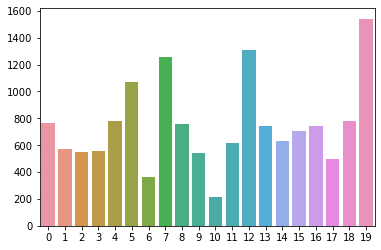

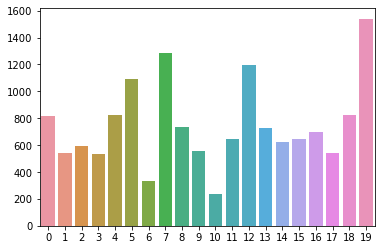

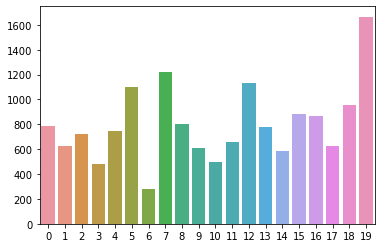

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  16000 non-null  int64
 1   behavior_id  16000 non-null  int64
dtypes: int64(2)
memory usage: 250.1 KB


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train_y = y
labels = np.argmax(proba_t[:,:20], axis=1)
oof_y = np.argmax(proba_oof[:,:20], axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(scores, 5))
data_path = '../../data/final_data/'
sub = pd.read_csv(data_path+'submit_example.csv')
sub['behavior_id'] = labels

vc = pd.Series(train_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = pd.Series(oof_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
sub.to_csv('all_stragety-add2net%.5f.csv' % scores, index=False)
sub.info()


In [28]:
!ls ../../data/final_data

sensor_test_final.csv  sensor_train_final.csv  submit_example.csv
